In [95]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any
import shap
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
 )
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedGroupKFold
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [96]:
df = pd.read_csv("diabetic_data.csv")
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [97]:
# Mapping for categorical features from IDS_mapping
discharge_disposition_id_mapping = {
1: "Discharged to home",
2: "Discharged/transferred to another short term hospital",
3: "Discharged/transferred to SNF",
4: "Discharged/transferred to ICF",
5: "Discharged/transferred to another type of inpatient care institution",
6: "Discharged/transferred to home with home health service",
7: "Left AMA",
8: "Discharged/transferred to home under care of Home IV provider",
9: "Admitted as an inpatient to this hospital",
10: "Neonate discharged to another hospital for neonatal aftercare",
11: "Expired",
12: "Still patient or expected to return for outpatient services",
13: "Hospice / home",
14: "Hospice / medical facility",
15: "Discharged/transferred within this institution to Medicare approved swing bed",
16: "Discharged/transferred/referred another institution for outpatient services",
17: "Discharged/transferred/referred to this institution for outpatient services",
18: "NULL",
19: "Expired at home. Medicaid only, hospice.",
20: "Expired in a medical facility. Medicaid only, hospice.",
21: "Expired, place unknown. Medicaid only, hospice.",
22: "Discharged/transferred to another rehab fac including rehab units of a hospital.",
23: "Discharged/transferred to a long term care hospital.",
24: "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.",
25: "Not Mapped",
26: "Unknown/Invalid",
30: "Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere",
27: "Discharged/transferred to a federal health care facility.",
28: "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital.",
29: "Discharged/transferred to a Critical Access Hospital (CAH)."
}

admission_type_id_mapping = { 
1 : 'Emergency',
2 : 'Urgent',
3 : 'Elective',
4 : 'Newborn',
5 : 'Not Available',
6 : 'NULL',
7 : 'Trauma Center',
8 : 'Not Mapped' }

admission_source_id = {
1 : 'Physician Referral',
2 : 'Clinic Referral',
3 : 'HMO Referral',
4 : 'Transfer from a hospital',
5 : 'Transfer from a Skilled Nursing Facility (SNF)',
6 : 'Transfer from another health care facility',
7 : 'Emergency Room',
8 : 'Court/Law Enforcement',
9 :  'Not Available',
10 : 'Transfer from critical access hospital',
11 : 'Normal Delivery',
12 : 'Premature Delivery',
13 : 'Sick Baby',
14 : 'Extramural Birth',
15 : 'Not Available',
17 : 'NULL',
18 : 'Transfer From Another Home Health Agency',
19 : 'Readmission to Same Home Health Agency',
20 : 'Not Mapped',
21 : 'Unknown/Invalid',
22 : 'Transfer from hospital inpt/same fac reslt in a sep claim',
23 : 'Born inside this hospital',
24 : 'Born outside this hospital',
25 : 'Transfer from Ambulatory Surgery Center',
26 : 'Transfer from Hospice'}

def map_icd9_to_group(code):
    """Map ICD-9 diagnosis codes to diagnostic groups"""
    if pd.isna(code) or code == '' or str(code).lower() == 'nan':
        return 'Unknown'

    # Convert to string and handle various formats
    code_str = str(code).strip()

    # Remove any trailing decimals like .0
    if '.' in code_str:
        try:
            # Handle decimal codes
            code_num = float(code_str)
        except:
            return 'Other'
    else:
        try:
            # Handle integer codes
            code_num = float(code_str)
        except:
            return 'Other'

    # Apply ICD-9 grouping rules
    if 250.0 <= code_num < 251.0:  # Diabetes: 250.xx
        return 'Diabetes'
    elif 1 <= code_num <=129:
        return 'Infectious and parasitic diseases'
    elif 140 <= code_num <= 239:  # Neoplasms
        return 'Neoplasms'
    elif 240 <= code_num <= 279:
        return 'Endocrine, nutritional and metabolic diseases, and immunity disorders'
    elif 280 <= code_num <= 289:  
        return 'diseases of the blood and blood-forming organs'
    elif 290 <= code_num <= 319:  
        return 'mental disorders'
    elif 320 <= code_num <= 389:  
        return 'diseases of the nervous system and sense organs'
    elif (390 <= code_num <= 459) or code_num == 785:  # Circulatory
        return 'Circulatory'
    elif (460 <= code_num <= 519) or code_num == 786:  # Respiratory
        return 'Respiratory'
    elif (520 <= code_num <= 579) or code_num == 787:  # Digestive
        return 'Digestive'
    elif (580 <= code_num <= 629) or code_num == 788:  # Genitourinary
        return 'Genitourinary'
    elif 630 <= code_num <= 679: 
        return 'complications of pregnancy, childbirth, and the puerperium'
    elif 680 <= code_num <= 709:  
        return 'diseases of the skin and subcutaneous tissue'
    elif 710 <= code_num <= 739:  
        return 'Musculoskeletal'
    elif 740 <= code_num <= 759:  
        return 'congenital anomalies'
    elif 760 <= code_num <= 779:  
        return 'certain conditions originating in the perinatal period'
    elif 780 <= code_num <= 799:  
        return 'symptoms, signs, and ill-defined conditions'
    elif 800 <= code_num <= 999:  # Injury
        return 'Injury'
    else:
        return 'Other'

In [98]:
# Apply the ID mappings to make categorical features more interpretable
df['discharge_disposition_desc'] = df['discharge_disposition_id'].map(discharge_disposition_id_mapping)
df['admission_type_desc'] = df['admission_type_id'].map(admission_type_id_mapping)
df['admission_source_desc'] = df['admission_source_id'].map(admission_source_id)

# Map ICD-9 diagnosis codes to diagnostic groups
df['diag_1_group'] = df['diag_1'].apply(map_icd9_to_group)
df['diag_2_group'] = df['diag_2'].apply(map_icd9_to_group)
df['diag_3_group'] = df['diag_3'].apply(map_icd9_to_group)

# Convert readmitted to binary target
# <30 days = 1 (high risk, needs intervention)
# NO or >30 days = 0 (lower risk)
df['readmitted_binary'] = (df['readmitted'] != '<30').astype(int)

In [99]:
def create_safe_patient_history_features(df):
    """
    Create patient history features WITHOUT data leakage
    
    Key principles to avoid leakage:
    1. Only use information from PRIOR encounters (not current or future)
    2. Use temporal ordering (encounter_id as proxy for time)
    3. Use .shift() to exclude current encounter from aggregations
    
    Returns: DataFrame with new history features
    """
    df = df.copy()
    original_columns = set(df.columns)

    # Sort by patient and encounter (encounter_id is chronological proxy)
    remove_patient_nbr_list = [493038, 23611986, 23738805, 67099194, 84365577, 89947233, 42491844, 33665094, 43466490, 42055272, 108707976, 39583782, 54686619, 33581808, 41325552, 151756061, 94422375, 32337963]
    df = df.sort_values(['patient_nbr', 'encounter_id']).reset_index(drop=True)
    df = df[~df['patient_nbr'].isin(remove_patient_nbr_list)]
    
    print("Creating patient history features (avoiding temporal leakage)...")
    
    # 1. Count of prior encounters (excluding current)
    df['prior_encounter_count'] = df.groupby('patient_nbr').cumcount()
    
    # 2. Prior readmission history (using .shift to exclude current encounter)
    # Use readmitted_binary if available, otherwise create it
    if 'readmitted_binary' not in df.columns:
        print("  ⚠️  Warning: readmitted_binary not found, creating it (<30 days = 1)")
        df['readmitted_binary'] = (df['readmitted'] != '<30').astype(int)
    
    # Count of prior 30-day readmissions (high risk - our target)
    df['prior_30day_readmission_count'] = (
        df.groupby('patient_nbr')['readmitted_binary']
        .shift(1)  # Exclude current encounter
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )
    
    # Also track any readmission (not just <30 days) for additional context
    df['was_readmitted_any'] = (df['readmitted'] != 'NO').astype(int)
    df['prior_was_readmitted_any'] = (
        df.groupby('patient_nbr')['was_readmitted_any']
        .shift(1)
        .fillna(0)
        .astype(int)
    )
    df['prior_any_readmission_count'] = (
        df.groupby('patient_nbr')['was_readmitted_any']
        .shift(1)  # Exclude current encounter
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )
    
    # 3. Prior total inpatient visits (cumulative)
    df['prior_total_inpatient'] = (
        df.groupby('patient_nbr')['number_inpatient']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )
    
    # 4. Prior total emergency visits
    df['prior_total_emergency'] = (
        df.groupby('patient_nbr')['number_emergency']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )
    
    # 5. Prior total outpatient visits
    df['prior_total_outpatient'] = (
        df.groupby('patient_nbr')['number_outpatient']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )
    
    # 6. Average time in hospital for prior encounters
    df['prior_avg_time_in_hospital'] = (
        df.groupby('patient_nbr')['time_in_hospital']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # 7. Prior medication count (number of medications prescribed)
    df['prior_avg_num_medications'] = (
        df.groupby('patient_nbr')['num_medications']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # 8. Prior lab procedures count
    df['prior_avg_num_lab_procedures'] = (
        df.groupby('patient_nbr')['num_lab_procedures']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # 9. Prior diagnosis count
    df['prior_avg_number_diagnoses'] = (
        df.groupby('patient_nbr')['number_diagnoses']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # 10. Is this a returning patient? (binary flag)
    df['is_returning_patient'] = (df['prior_encounter_count'] > 0).astype(int)
    
    # 11. Prior 30-day readmission rate (for returning patients)
    df['prior_30day_readmission_rate'] = df.apply(
        lambda row: row['prior_30day_readmission_count'] / row['prior_encounter_count'] 
        if row['prior_encounter_count'] > 0 else 0, axis=1
    )
    
    # ========== NEW ADVANCED FEATURES ==========

    # 12. Polypharmacy risk score (exponential risk above 5 medications)
    df['polypharmacy_risk'] = df['num_medications'].apply(
        lambda x: np.exp((x - 5) / 10) if x > 5 else 0
    )
    
    # 13. Medication count change from history
    df['medication_count_change'] = (
        df['num_medications'] - df['prior_avg_num_medications']
    )
    
    # 14. High-risk medication combination (Insulin + diabetes meds + anticoagulants proxy)
    # Using num_medications > 15 as proxy for complex medication regimen
    diabetes_med_cols = ['insulin', 'metformin', 'glipizide', 'glyburide', 'glimepiride']
    if any(col in df.columns for col in diabetes_med_cols):
        df['has_diabetes_meds'] = df[[col for col in diabetes_med_cols if col in df.columns]].apply(
            lambda row: (row != 'No').any() and (row != 'Steady').any(), axis=1
        ).astype(int)
        df['high_risk_med_combo'] = (
            (df['has_diabetes_meds'] == 1) & (df['num_medications'] > 10)
        ).astype(int)
    else:
        # Fallback if medication columns not available
        df['high_risk_med_combo'] = (df['num_medications'] > 15).astype(int)
    
    # 15. Healthcare utilization trend (acceleration indicator)
    df['healthcare_utilization_trend'] = df.apply(
        lambda row: (row['number_emergency'] + row['number_inpatient']) / max(row['prior_encounter_count'], 1),
        axis=1
    )
    
    # 16. High-confidence readmission signal
    # Prior 30-day readmission + emergency + long stay + high medications
    df['high_confidence_readmission'] = (
        (df['prior_30day_readmission_count'] > 0) & 
        (df['admission_type_id'] == 1) &  # Emergency admission
        (df['time_in_hospital'] >= 7) &
        (df['num_medications'] > 15)
    ).astype(int)
    
    # 17. Low-risk exclusion features
    # Young + no complications + short stay + elective
    age_numeric = df['age'].map({
        '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
        '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
        '[80-90)': 85, '[90-100)': 95
    }) if 'age' in df.columns else 50  # Default to middle age if not available
    
    df['low_risk_profile'] = (
        (age_numeric < 40) &
        (df['number_diagnoses'] <= 5) &
        (df['time_in_hospital'] <= 3) &
        (df['admission_type_id'] == 3)  # Elective admission
    ).astype(int)
    
    # 18. Log transformations for skewed distributions
    df['log_prior_encounter_count'] = np.log1p(df['prior_encounter_count'])
    df['log_num_procedures'] = np.log1p(df['num_procedures'])
    
    # 19. Cross features between discharge disposition and medications
    # High medication count at risky discharge destinations
    risky_discharge_ids = [1, 6, 7, 13]  # Home, home with service, AMA, hospice/home
    if 'discharge_disposition_id' in df.columns:
        df['risky_discharge_high_meds'] = (
            (df['discharge_disposition_id'].isin(risky_discharge_ids)) &
            (df['num_medications'] > 10)
        ).astype(int)
    else:
        df['risky_discharge_high_meds'] = 0
    
    # 20. Number of unique diagnosis groups from all historic visits
    # Count unique diagnosis groups seen across patient history
    df['historic_unique_diag_groups'] = 0  # Initialize
    
    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        # For each patient, track unique diagnosis groups from prior encounters
        for patient in df['patient_nbr'].unique():
            patient_mask = df['patient_nbr'] == patient
            patient_data = df[patient_mask].copy()
            
            # For each encounter, count unique diagnoses from ALL prior encounters
            unique_counts = []
            for idx in range(len(patient_data)):
                if idx == 0:
                    unique_counts.append(0)  # First encounter has no history
                else:
                    # Get all diagnoses from prior encounters
                    prior_diags = set()
                    for i in range(idx):
                        prior_diags.update([
                            patient_data.iloc[i]['diag_1_group'],
                            patient_data.iloc[i]['diag_2_group'],
                            patient_data.iloc[i]['diag_3_group']
                        ])
                    prior_diags.discard('Unknown')  # Remove unknowns
                    prior_diags.discard(None)
                    unique_counts.append(len(prior_diags))
            
            df.loc[patient_mask, 'historic_unique_diag_groups'] = unique_counts

    
    if all(col in df.columns for col in diag_group_cols):
        def _clean_diag(value):
            if pd.isna(value):
                return np.nan
            val = str(value).strip()
            if val.lower() in {'unknown', 'nan', 'none', ''}:
                return np.nan
            return val

        records = []
        for patient, patient_df in df.groupby('patient_nbr', sort=False):
            last_readmitted_diags = [np.nan, np.nan, np.nan]
            prior_readmitted_union: set[str] = set()
            patient_rows = []
            for _, row in patient_df.iterrows():
                current_diags = [_clean_diag(row[col]) for col in diag_group_cols]
                current_diag_set = {val for val in current_diags if pd.notna(val)}

                overlap = prior_readmitted_union & current_diag_set
                patient_rows.append({
                    'prior_readmitted_diag_1_group': last_readmitted_diags[0],
                    'prior_readmitted_diag_2_group': last_readmitted_diags[1],
                    'prior_readmitted_diag_3_group': last_readmitted_diags[2],
                    'prior_readmitted_diag_match_flag': int(bool(overlap)),
                    'prior_readmitted_diag_match_count': len(overlap)
                })

                if row['readmitted_binary'] == 1:
                    last_readmitted_diags = current_diags
                    prior_readmitted_union.update(current_diag_set)
            records.append(pd.DataFrame(patient_rows, index=patient_df.index))
        diag_history = pd.concat(records).sort_index()
        df = df.join(diag_history)
    else:
        df['prior_readmitted_diag_1_group'] = np.nan
        df['prior_readmitted_diag_2_group'] = np.nan
        df['prior_readmitted_diag_3_group'] = np.nan
        df['prior_readmitted_diag_match_flag'] = 0
        df['prior_readmitted_diag_match_count'] = 0
    
    new_feature_names = sorted(set(df.columns) - original_columns)
    print(f"✓ Created {len(new_feature_names)} patient history features without data leakage")
    print(f"  - All features use only PRIOR encounters (via .shift(1))")
    print(f"  - First encounter for each patient has 0/NaN values (no prior history)")
    print(f"  - Uses readmitted_binary (30-day readmission) as target-aligned feature")
    print(f"  - Added 9 NEW advanced features for improved F1 score")
    if new_feature_names:
        preview = ", ".join(new_feature_names[:10])
        print(f"  - Sample new features: {preview}")

    # Verification check
    print("\n=== Leakage Check ===")
    first_encounters = df[df['prior_encounter_count'] == 0]
    print(f"First encounters: {len(first_encounters)}")
    print(f"Prior 30-day readmission count for first encounters (should be 0): {first_encounters['prior_30day_readmission_count'].sum()}")
    print(f"Prior any readmission count for first encounters (should be 0): {first_encounters['prior_any_readmission_count'].sum()}")
    
    # Show feature summary
    print("\n=== New Patient History Features ===")
    print("1. prior_encounter_count - Count of previous encounters")
    print("2. prior_30day_readmission_count - Count of prior <30 day readmissions (TARGET-ALIGNED)")
    print("3. prior_any_readmission_count - Count of any prior readmissions")
    print("4. prior_was_readmitted_any - Whether the patient was readmitted in the immediately previous encounter")
    print("5. prior_readmitted_diag_1_group - Latest diagnosis group 1 from a prior readmitted encounter")
    print("6. prior_readmitted_diag_2_group - Latest diagnosis group 2 from a prior readmitted encounter")
    print("7. prior_readmitted_diag_3_group - Latest diagnosis group 3 from a prior readmitted encounter")
    print("8. prior_readmitted_diag_match_flag - Whether current diagnosis groups overlap with any prior readmitted diagnosis group")
    print("9. prior_readmitted_diag_match_count - Number of overlapping diagnosis groups with prior readmitted encounters")
    print("10. prior_total_inpatient - Cumulative prior inpatient visits")
    print("11. prior_total_emergency - Cumulative prior emergency visits")
    print("12. prior_total_outpatient - Cumulative prior outpatient visits")
    print("13. prior_avg_time_in_hospital - Average prior hospital stay")
    print("14. prior_avg_num_medications - Average prior medications")
    print("15. prior_avg_num_lab_procedures - Average prior lab procedures")
    print("16. prior_avg_number_diagnoses - Average prior diagnoses")
    print("17. is_returning_patient - Binary flag for returning patients")
    print("18. prior_30day_readmission_rate - Rate of 30-day readmissions")

    print("\n=== NEW Advanced Features (for F1 improvement) ===")
    print("19. polypharmacy_risk - Exponential risk score for high medication counts (>5)")
    print("20. medication_count_change - Change from historical average medications")
    print("21. high_risk_med_combo - Diabetes meds + high medication count indicator")
    print("22. healthcare_utilization_trend - Acceleration of healthcare use")
    print("23. high_confidence_readmission - Multiple high-risk factors combined")
    print("24. low_risk_profile - Young + uncomplicated + short stay + elective")
    print("25. log_prior_encounter_count - Log transform of encounter history")
    print("26. log_num_procedures - Log transform of procedures")
    print("27. risky_discharge_high_meds - Risky discharge destination + high meds")
    print("28. historic_unique_diag_groups - Count of unique diagnosis categories in history")

    
    return df

In [100]:
def create_advanced_features(df):
    """
    Combined advanced engineered features for encounter-level modeling.
    """
    from sklearn.preprocessing import KBinsDiscretizer

    df = df.copy()
    original_columns = set(df.columns)

    print("=" * 80)
    print("CREATING ADVANCED FEATURES")
    print("=" * 80)

    def to_series(values):
        if isinstance(values, pd.Series):
            return values
        return pd.Series(values, index=df.index)

    def safe_divide(numerator, denominator):
        numerator = to_series(numerator)
        denominator = to_series(denominator)
        denominator = denominator.replace(0, np.nan)
        result = numerator / denominator
        return result.replace([np.inf, -np.inf], np.nan).fillna(0)

    zeros = lambda: pd.Series(0.0, index=df.index)

    # 1. Domain-specific medical features
    print("\n1️⃣  Creating domain-specific medical features...")
    encounter_cols = [col for col in ['number_inpatient', 'number_emergency', 'number_outpatient'] if col in df.columns]
    if encounter_cols:
        total_encounters = df[encounter_cols].sum(axis=1)
    else:
        total_encounters = zeros()
    df['total_healthcare_encounters'] = total_encounters

    df['emergency_ratio'] = safe_divide(df['number_emergency'], total_encounters) if 'number_emergency' in df.columns else zeros()
    df['inpatient_ratio'] = safe_divide(df['number_inpatient'], total_encounters) if 'number_inpatient' in df.columns else zeros()
    df['outpatient_ratio'] = safe_divide(df['number_outpatient'], total_encounters) if 'number_outpatient' in df.columns else zeros()

    complexity_cols = [col for col in ['num_procedures', 'num_medications', 'number_diagnoses'] if col in df.columns]
    if complexity_cols:
        df['clinical_complexity_score'] = df[complexity_cols].sum(axis=1)

    if 'time_in_hospital' in df.columns:
        stay = df['time_in_hospital']
        if 'num_medications' in df.columns:
            df['medication_intensity'] = safe_divide(df['num_medications'], stay)
        if 'num_lab_procedures' in df.columns:
            df['lab_intensity'] = safe_divide(df['num_lab_procedures'], stay)
        if 'num_procedures' in df.columns:
            df['procedure_intensity'] = safe_divide(df['num_procedures'], stay)

    if {'num_medications', 'number_diagnoses'} <= set(df.columns):
        df['medication_per_diagnosis'] = safe_divide(df['num_medications'], df['number_diagnoses'])
    if {'num_lab_procedures', 'number_diagnoses'} <= set(df.columns):
        df['lab_per_diagnosis'] = safe_divide(df['num_lab_procedures'], df['number_diagnoses'])
    if {'num_procedures', 'number_diagnoses'} <= set(df.columns):
        df['procedures_per_diagnosis'] = safe_divide(df['num_procedures'], df['number_diagnoses'])

    print("   ✓ Created utilisation, intensity, and ratio features")

    # 2. Patient history interaction features
    print("\n2️⃣  Creating patient history interaction features...")
    if 'prior_encounter_count' in df.columns:
        df['weighted_prior_readmission_risk'] = df['prior_30day_readmission_rate'] * df['prior_encounter_count']
        df['current_vs_avg_hospitalization'] = df.apply(
            lambda row: row['time_in_hospital'] / row['prior_avg_time_in_hospital'] if row['prior_avg_time_in_hospital'] > 0 else 1,
            axis=1
        )
        df['current_vs_avg_medications'] = df.apply(
            lambda row: row['num_medications'] / row['prior_avg_num_medications'] if row['prior_avg_num_medications'] > 0 else 1,
            axis=1
        )
        df['current_vs_avg_procedures'] = df.apply(
            lambda row: row['num_lab_procedures'] / row['prior_avg_num_lab_procedures'] if row['prior_avg_num_lab_procedures'] > 0 else 1,
            axis=1
        )
        df['hospitalization_escalation'] = (df['current_vs_avg_hospitalization'] > 1.2).astype(int)
        df['medication_escalation'] = (df['current_vs_avg_medications'] > 1.5).astype(int)
        print("   ✓ Created 6 patient history interaction features")
    else:
        print("   • Skipped (requires patient history features)")

    # 3. Diabetes medication combination features
    print("\n3️⃣  Creating diabetes medication combination features...")
    diabetes_meds = sorted({
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
        'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone'
    })
    available_meds = [col for col in diabetes_meds if col in df.columns]
    if available_meds:
        med_changes = df[available_meds]
        df['diabetes_med_change_count'] = med_changes.apply(lambda row: sum(row != 'No'), axis=1)
        df['any_diabetes_med_change'] = (df['diabetes_med_change_count'] > 0).astype(int)
        df['has_diabetes_meds'] = med_changes.apply(
            lambda row: int(any(val not in ['No', 'Steady'] for val in row)),
            axis=1
        )
        if 'num_medications' in df.columns:
            df['high_risk_med_combo'] = (
                (df['has_diabetes_meds'] == 1) & (df['num_medications'] > 10)
            ).astype(int)
        if 'insulin' in df.columns:
            df['insulin_changed'] = (df['insulin'] != 'No').astype(int)
        print("   ✓ Created diabetes medication interaction features")
    else:
        print("   • Skipped (medication columns not available)")

    # 4. Age-related cross features
    print("\n4️⃣  Creating age-related cross features...")
    if 'age_numeric' not in df.columns and 'age' in df.columns:
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
            '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
            '[80-90)': 85, '[90-100)': 95
        }
        df['age_numeric'] = df['age'].map(age_mapping)
    if 'age_numeric' in df.columns:
        df['is_child'] = (df['age_numeric'] <= 20).astype(int)
        df['is_elderly'] = (df['age_numeric'] >= 70).astype(int)
        if 'clinical_complexity_score' in df.columns:
            df['age_complexity_interaction'] = df['age_numeric'] * df['clinical_complexity_score'] / 1000
        if 'num_medications' in df.columns:
            df['age_medication_interaction'] = df['age_numeric'] * df['num_medications'] / 100
        print("   ✓ Created age cross features")
    else:
        print("   • Skipped (age column not available)")

    # 5. Admission-discharge pattern features
    print("\n5️⃣  Creating admission-discharge pattern features...")
    if 'admission_type_desc' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_desc'] == 'Emergency').astype(int)
    elif 'admission_type_id' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_id'] == 1).astype(int)

    if 'discharge_disposition_desc' in df.columns:
        high_risk_discharge = [
            'Expired', 'Hospice / home', 'Hospice / medical facility',
            'Expired at home. Medicaid only, hospice',
            'Expired in a medical facility. Medicaid only, hospice',
            'Expired, place unknown. Medicaid only, hospice'
        ]
        df['high_risk_discharge'] = df['discharge_disposition_desc'].apply(
            lambda x: 1 if any(risk in str(x) for risk in high_risk_discharge) else 0
        )
    elif 'discharge_disposition_id' in df.columns and 'high_risk_discharge' not in df.columns:
        df['high_risk_discharge'] = df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]).astype(int)

    if 'time_in_hospital' in df.columns:
        df['long_hospital_stay'] = (df['time_in_hospital'] > 7).astype(int)

    if {'age_numeric', 'number_diagnoses', 'time_in_hospital', 'admission_type_id'}.issubset(df.columns) and 'low_risk_profile' not in df.columns:
        df['low_risk_profile'] = (
            (df['age_numeric'] < 40) &
            (df['number_diagnoses'] <= 5) &
            (df['time_in_hospital'] <= 3) &
            (df['admission_type_id'] == 3)
        ).astype(int)

    print("   ✓ Created admission/discharge risk indicators")

    # 6. Medication and laboratory heuristics
    print("\n6️⃣  Creating medication and lab heuristics...")
    if 'num_medications' in df.columns and 'polypharmacy_risk' not in df.columns:
        df['polypharmacy_risk'] = np.where(df['num_medications'] > 5, np.exp((df['num_medications'] - 5) / 10), 0)
    if 'num_medications' in df.columns and 'log_num_medications' not in df.columns:
        df['log_num_medications'] = np.log1p(df['num_medications'])
    if {'log_num_medications', 'time_in_hospital'}.issubset(df.columns) and 'medication_burden_score' not in df.columns:
        df['medication_burden_score'] = df['log_num_medications'] * df['time_in_hospital']
    if 'num_procedures' in df.columns and 'log_num_procedures' not in df.columns:
        df['log_num_procedures'] = np.log1p(df['num_procedures'])
    if 'time_in_hospital' in df.columns and 'log_time_in_hospital' not in df.columns:
        df['log_time_in_hospital'] = np.log1p(df['time_in_hospital'])
    if 'total_healthcare_encounters' in df.columns and 'log_total_healthcare_encounters' not in df.columns:
        df['log_total_healthcare_encounters'] = np.log1p(df['total_healthcare_encounters'])
    if 'A1Cresult' in df.columns and 'a1c_abnormal_flag' not in df.columns:
        df['a1c_abnormal_flag'] = df['A1Cresult'].isin(['>7', '>8']).astype(int)
    if 'max_glu_serum' in df.columns and 'glu_lab_flag' not in df.columns:
        df['glu_lab_flag'] = df['max_glu_serum'].isin(['>200', '>300']).astype(int)
    print("   ✓ Created medication/lab heuristic features")

    # 7. Quantile-based binning for non-linear patterns
    print("\n7️⃣  Creating quantile-based binned features (n_bins=6)...")
    n_bins = 6
    binning_features = [
        feature for feature in [
            'time_in_hospital', 'num_medications', 'num_lab_procedures',
            'number_diagnoses', 'num_procedures', 'clinical_complexity_score',
            'total_healthcare_encounters'
        ] if feature in df.columns and df[feature].nunique() > 1
    ]
    for feature in binning_features:
        discretizer = KBinsDiscretizer(
            n_bins=min(n_bins, df[feature].nunique()),
            encode='ordinal',
            strategy='quantile',
            subsample=None
        )
        df[f'{feature}_bin'] = discretizer.fit_transform(df[[feature]]).astype(int)
    print(f"   ✓ Created {len(binning_features)} quantile-binned features")

    # 8. Diagnosis pattern features
    print("\n8️⃣  Creating diagnosis pattern features...")
    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        df['diabetes_diagnosis_count'] = df[diag_group_cols].apply(
            lambda row: sum(val == 'Diabetes' for val in row), axis=1
        )
        df['primary_diabetes'] = (df['diag_1_group'] == 'Diabetes').astype(int)
        df['has_circulatory_complication'] = df[diag_group_cols].apply(
            lambda row: int(any(val == 'Circulatory' for val in row)),
            axis=1
        )
        if 'circulatory_issue_flag' not in df.columns:
            df['circulatory_issue_flag'] = df['has_circulatory_complication']
        df['diagnosis_diversity'] = df[diag_group_cols].apply(
            lambda row: len(set(row)), axis=1
        )
        print("   ✓ Created diagnosis pattern features")
    else:
        print("   • Skipped (diagnosis group columns not available)")

    # 9. Diagnosis cross features and history interactions
    print("\n9️⃣  Creating diagnosis cross features...")
    if all(col in df.columns for col in ['diag_1', 'diag_2', 'diag_3']):
        df['diag_123'] = df['diag_1'].astype(str) + '_' + df['diag_2'].astype(str) + '_' + df['diag_3'].astype(str)
        print(f"   ✓ Created diag_123 (unique combinations: {df['diag_123'].nunique()})")
    if all(col in df.columns for col in diag_group_cols):
        df['diag_123_group'] = (
            df['diag_1_group'].astype(str) + '_' +
            df['diag_2_group'].astype(str) + '_' +
            df['diag_3_group'].astype(str)
        )
        created_cross = 0
        for feat in binning_features:
            bin_col = f'{feat}_bin'
            if bin_col in df.columns:
                df[f'diag_123_group_{feat}_bin'] = (
                    df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                )
                created_cross += 1
        print(f"   ✓ Created diagnosis group × numeric cross features for {created_cross} new attributes")
        print(f"   ✓ Created diag_123_group (unique combinations: {df['diag_123_group'].nunique()})")
        created_cross = 0
        if 'prior_encounter_count' in df.columns:
            history_features = [
                'prior_encounter_count',
                'prior_30day_readmission_count',
                'prior_avg_time_in_hospital',
                'prior_avg_num_medications',
                'prior_avg_num_lab_procedures',
                'prior_avg_num_procedures'
            ]
            for hist_feat in history_features:
                if hist_feat in df.columns:
                    bin_col = f'{hist_feat}_bin'
                    if bin_col not in df.columns:
                        discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile', subsample=None)
                        df[bin_col] = discretizer.fit_transform(df[[hist_feat]]).astype(int)
                    df[f'diag_123_group_{hist_feat}_bin'] = (
                        df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                    )
                    created_cross += 1
            print(f"   ✓ Created diagnosis group × history cross features for {created_cross} history attributes")

    print("\n" + "=" * 80)
    print("SUMMARY: Advanced Feature Engineering Complete")
    print("=" * 80)
    new_features = sorted(set(df.columns) - original_columns)
    print(f"✅ Created {len(new_features)} new features")
    if new_features:
        preview = ", ".join(new_features[:10])
        print(f"   Sample new features: {preview}")
    return df

In [101]:
def create_advanced_encodings(df, target_col='readmitted_binary', train_indices=None):
    """
    Create advanced encodings for categorical variables:
    - Frequency encoding
    - Target encoding (with smoothing to prevent overfitting)
    - Count encoding
    - Binary encoding for high cardinality
    
    Parameters:
    - df: DataFrame
    - target_col: name of target column for target encoding
    - train_indices: indices of training set (to prevent leakage in target encoding)
    
    Returns: DataFrame with encoded features
    """
    df = df.copy()
    
    print("="*80)
    print("CREATING ADVANCED ENCODINGS")
    print("="*80)
    
    # If no train_indices provided, use all data (but warn about potential leakage)
    if train_indices is None:
        print("⚠️  WARNING: No train_indices provided. Using full dataset for encoding.")
        print("   This is OK for exploration, but use proper train/test split for modeling!")
        train_indices = df.index
    
    # ===================================================================
    # 1. FREQUENCY ENCODING
    # ===================================================================
    print("\n1️⃣  Creating frequency encodings...")
    
    # High cardinality categorical features that benefit from frequency encoding
    freq_encode_cols = []
    
    # Identify categorical columns with many unique values
    for col in df.select_dtypes(include=['object']).columns:
        nunique = df[col].nunique()
        if 10 < nunique < 1000 and col != target_col:  # Skip if too few or too many
            freq_encode_cols.append(col)
    
    freq_encoded = 0
    for col in freq_encode_cols[:5]:  # Limit to top 5 to avoid too many features
        freq_map = df.loc[train_indices, col].value_counts(normalize=True).to_dict()
        df[f'{col}_frequency'] = df[col].map(freq_map).fillna(0)
        freq_encoded += 1
    
    print(f"   ✓ Created {freq_encoded} frequency-encoded features")
    
    # ===================================================================
    # 2. COUNT ENCODING
    # ===================================================================
    print("\n3️⃣  Creating count encodings...")
    
    count_encoded = 0
    for col in ['diag_1', 'diag_2', 'diag_3'][:3]:  # High cardinality diagnosis codes
        if col in df.columns:
            count_map = df.loc[train_indices, col].value_counts().to_dict()
            df[f'{col}_count'] = df[col].map(count_map).fillna(0)
            count_encoded += 1
    
    print(f"   ✓ Created {count_encoded} count-encoded features")
    
    # ===================================================================
    # 4. BINARY ENCODING for specific binary features
    # ===================================================================
    print("\n4️⃣  Creating binary encodings...")
    
    binary_cols = {
        'gender': {'Male': 1, 'Female': 0},
        'change': {'Ch': 1, 'No': 0},
        'diabetesMed': {'Yes': 1, 'No': 0}
    }
    
    binary_encoded = 0
    for col, mapping in binary_cols.items():
        if col in df.columns:
            df[f'{col}_binary'] = df[col].map(mapping).fillna(0)
            binary_encoded += 1
    
    print(f"   ✓ Created {binary_encoded} binary-encoded features")
    
    # ===================================================================
    # 5. ORDINAL ENCODING for naturally ordered categories
    # ===================================================================
    print("\n5️⃣  Creating ordinal encodings...")
    
    # Age is already ordinal, just encode it
    if 'age' in df.columns and 'age_numeric' not in df.columns:
        age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                     '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
        df['age_ordinal'] = df['age'].map({age: i for i, age in enumerate(age_order)})
    
    # Encode medication change levels if they exist
    med_change_order = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}
    ordinal_encoded = 0
    
    for col in df.columns:
        if 'metformin' in col.lower() or 'insulin' in col.lower():
            if df[col].dtype == 'object' and set(df[col].unique()).issubset(set(med_change_order.keys()) | {np.nan}):
                df[f'{col}_ordinal'] = df[col].map(med_change_order).fillna(0)
                ordinal_encoded += 1
    
    print(f"   ✓ Created {ordinal_encoded} ordinal-encoded features")
    
    print("\n" + "="*80)
    print("SUMMARY: Advanced Encoding Complete")
    print("="*80)
    print(f"✅ Created encodings:")
    print(f"  - Frequency encoding: {freq_encoded}")
    print(f"  - Count encoding: {count_encoded}")
    print(f"  - Binary encoding: {binary_encoded}")
    print(f"  - Ordinal encoding: {ordinal_encoded}")
    print(f"  TOTAL: ~{freq_encoded + count_encoded + binary_encoded + ordinal_encoded} new encoded features")
    print(f"\n⚠️  NOTE: Target encoding is handled in the sklearn Pipeline to prevent data leakage!")
    
    return df

In [102]:
class SafeTargetEncoder:
    """
    Proper target encoder that prevents data leakage.
    
    Key features:
    - Fits ONLY on training data
    - Uses smoothing to prevent overfitting
    - Handles unseen categories gracefully
    - Works with cross-validation
    """
    
    def __init__(self, columns, alpha=10):
        """
        Parameters:
        - columns: list of column names to encode
        - alpha: smoothing parameter (higher = more regularization)
        """
        self.columns = columns
        self.alpha = alpha
        self.encodings = {}
        self.global_mean = None
        
    def fit(self, X, y):
        """
        Fit encoder on training data only.
        
        Parameters:
        - X: DataFrame with features
        - y: Target variable (Series or array)
        """
        # Convert y to Series if it's a numpy array
        if not isinstance(y, pd.Series):
            y = pd.Series(y, index=X.index)
        
        self.global_mean = y.mean()
        
        for col in self.columns:
            if col not in X.columns:
                print(f"⚠️  Warning: Column '{col}' not found in data, skipping...")
                continue
            
            # Create temporary DataFrame for groupby
            temp_df = pd.DataFrame({
                'category': X[col].values,
                'target': y.values
            })
            
            # Calculate smoothed target encoding
            # Formula: (count * mean + alpha * global_mean) / (count + alpha)
            agg = temp_df.groupby('category')['target'].agg(['mean', 'count'])
            smoothed = (agg['count'] * agg['mean'] + self.alpha * self.global_mean) / (agg['count'] + self.alpha)
            
            self.encodings[col] = smoothed.to_dict()
        
        return self
    
    def transform(self, X):
        """
        Transform data using fitted encodings.
        
        For unseen categories, uses global mean.
        """
        X = X.copy()
        
        for col in self.columns:
            if col not in X.columns or col not in self.encodings:
                continue
            
            # Map using learned encodings, fill unseen with global mean
            X[f'{col}_target_enc'] = X[col].map(self.encodings[col]).fillna(self.global_mean)
        
        return X
    
    def fit_transform(self, X, y):
        """Fit and transform in one step (only use on training data!)"""
        self.fit(X, y)
        return self.transform(X)


class SafeFrequencyEncoder:
    """
    Frequency encoder that prevents data leakage.
    Encodes categories by their frequency in training data.
    """
    
    def __init__(self, columns):
        self.columns = columns
        self.encodings = {}
    
    def fit(self, X):
        """Fit on training data only"""
        for col in self.columns:
            if col not in X.columns:
                continue
            
            freq_map = X[col].value_counts(normalize=True).to_dict()
            self.encodings[col] = freq_map
        
        return self
    
    def transform(self, X):
        """Transform using fitted frequencies"""
        X = X.copy()
        
        for col in self.columns:
            if col not in X.columns or col not in self.encodings:
                continue
            
            X[f'{col}_frequency'] = X[col].map(self.encodings[col]).fillna(0)
        
        return X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


class SafeCountEncoder:
    """
    Count encoder that prevents data leakage.
    Encodes categories by their count in training data.
    """
    
    def __init__(self, columns):
        self.columns = columns
        self.encodings = {}
    
    def fit(self, X):
        """Fit on training data only"""
        for col in self.columns:
            if col not in X.columns:
                continue
            
            count_map = X[col].value_counts().to_dict()
            self.encodings[col] = count_map
        
        return self
    
    def transform(self, X):
        """Transform using fitted counts"""
        X = X.copy()
        
        for col in self.columns:
            if col not in X.columns or col not in self.encodings:
                continue
            
            X[f'{col}_count'] = X[col].map(self.encodings[col]).fillna(0)
        
        return X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


print("✅ Safe encoder classes defined:")
print("   - SafeTargetEncoder")
print("   - SafeFrequencyEncoder")
print("   - SafeCountEncoder")

✅ Safe encoder classes defined:
   - SafeTargetEncoder
   - SafeFrequencyEncoder
   - SafeCountEncoder


In [103]:
def remove_features(df, target_col: str = 'readmitted_binary', preserve_cols: list[str] | None = None) -> pd.DataFrame:
    """
    Remove identifier-like, leakage-prone, and near-constant features while preserving requested columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    target_col : str
        Name of the target column to keep.
    preserve_cols : list[str] | None
        Additional columns that must be preserved (e.g., grouping identifiers).

    Returns
    -------
    pd.DataFrame
        DataFrame with low-information columns removed.
    """
    preserve = set(preserve_cols or [])
    preserve.add(target_col)

    id_like_cols = ['encounter_id', 'patient_nbr', 'payer_code', 'weight']
    raw_leakage_cols = {'readmitted'}
    prior_feature_allowlist = {
        'prior_30day_readmission_count',
        'prior_any_readmission_count',
        'prior_30day_readmission_rate',
        'prior_was_readmitted_any',
        'high_confidence_readmission'
    }

    near_constant_cols: list[str] = []
    for col in df.columns:
        if col in preserve:
            continue
        value_counts = df[col].value_counts(dropna=False, normalize=True)
        if not value_counts.empty and value_counts.iloc[0] >= 0.99:
            near_constant_cols.append(col)

    leakage_cols: list[str] = []
    for col in df.columns:
        if col in preserve:
            continue
        if col in raw_leakage_cols:
            leakage_cols.append(col)
        elif col == 'was_readmitted_any':
            leakage_cols.append(col)
        elif ('readmitted' in col.lower() and col not in prior_feature_allowlist
              and col not in raw_leakage_cols and col != target_col):
            leakage_cols.append(col)

    to_drop = [col for col in id_like_cols if col in df.columns and col not in preserve]
    to_drop.extend([col for col in near_constant_cols if col not in preserve])
    to_drop.extend([col for col in leakage_cols if col not in preserve])

    if to_drop:
        unique_drop = sorted(set(to_drop))
        print(f"Dropping potential leakage/ID columns: {unique_drop}")
        return df.drop(columns=unique_drop, errors='ignore')
    return df.copy()

In [104]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Custom feature selector that replicates the previous voting logic while remaining sklearn-compatible."""
    def __init__(self, correlation_threshold: float = 0.9, variance_threshold: float = 0.95, random_state: int = 42, top_k_fraction: float = 0.15, min_top_k: int = 50):
        self.correlation_threshold = correlation_threshold
        self.variance_threshold = variance_threshold
        self.random_state = random_state
        self.top_k_fraction = top_k_fraction
        self.min_top_k = min_top_k
        
        # Attributes populated during fit()
        self._input_columns: list[str] | None = None
        self._uncorrelated_columns: list[str] | None = None
        self.correlated_to_drop_: list[str] = []
        self.mutual_info_series_: pd.Series | None = None
        self.pca_feature_scores_: pd.Series = pd.Series(dtype=float)
        self.pca_selected_features_: list[str] = []
        self.pca_components_retained_: int = 0
        self.pca_cumulative_variance_: float = 0.0
        self.numeric_feature_count_: int = 0
        self.rf_feature_importance_: pd.Series | None = None
        self.selected_features_: list[str] = []
        self.support_mask_: np.ndarray | None = None
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y, index=X.index)
        
        self._input_columns = list(X.columns)
        self.correlated_to_drop_ = []
        if X.shape[1] > 1:
            corr_matrix = X.corr().abs()
            upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            self.correlated_to_drop_ = [column for column in upper_tri.columns if any(upper_tri[column] > self.correlation_threshold)]
        
        X_uncorr = X.drop(columns=self.correlated_to_drop_, errors='ignore')
        self._uncorrelated_columns = list(X_uncorr.columns)
        
        mi_scores = mutual_info_classif(X_uncorr, y, random_state=self.random_state)
        self.mutual_info_series_ = pd.Series(mi_scores, index=X_uncorr.columns).sort_values(ascending=False)
        
        numeric_cols = X_uncorr.select_dtypes(include=[np.number]).columns.tolist()
        self.numeric_feature_count_ = len(numeric_cols)
        self.pca_feature_scores_ = pd.Series(dtype=float)
        self.pca_selected_features_ = []
        self.pca_components_retained_ = 0
        self.pca_cumulative_variance_ = 0.0
        if numeric_cols:
            scaler_for_pca = StandardScaler(with_mean=False)
            X_numeric = X_uncorr[numeric_cols]
            X_numeric_scaled = scaler_for_pca.fit_transform(X_numeric)
            
            pca_full = PCA(random_state=self.random_state)
            pca_full.fit(X_numeric_scaled)
            cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
            n_components = np.searchsorted(cumulative_variance, self.variance_threshold) + 1
            n_components = min(n_components, X_numeric.shape[1])
            
            pca = PCA(n_components=n_components, random_state=self.random_state)
            pca.fit(X_numeric_scaled)
            
            loadings = np.abs(pca.components_)
            variance_weights = pca.explained_variance_ratio_.reshape(-1, 1)
            feature_contrib = (loadings * variance_weights).sum(axis=0)
            feature_contrib = feature_contrib / feature_contrib.sum()
            self.pca_feature_scores_ = pd.Series(feature_contrib, index=numeric_cols).sort_values(ascending=False)
            cumulative_feature_contrib = self.pca_feature_scores_.cumsum()
            self.pca_selected_features_ = cumulative_feature_contrib.index[cumulative_feature_contrib <= self.variance_threshold].tolist()
            if not self.pca_selected_features_ and not self.pca_feature_scores_.empty:
                self.pca_selected_features_ = [self.pca_feature_scores_.index[0]]
            self.pca_components_retained_ = n_components
            self.pca_cumulative_variance_ = cumulative_variance[n_components - 1] if n_components > 0 else 0.0
        
        rf_selector = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            random_state=self.random_state,
            n_jobs=-1,
            class_weight='balanced_subsample'
        )
        rf_selector.fit(X_uncorr, y)
        self.rf_feature_importance_ = pd.Series(
            rf_selector.feature_importances_, index=X_uncorr.columns
        ).sort_values(ascending=False)
        
        top_k = max(self.min_top_k, int(self.top_k_fraction * len(X_uncorr.columns)))
        mi_top = set(self.mutual_info_series_.head(top_k).index) if self.mutual_info_series_ is not None else set()
        rf_top = set(self.rf_feature_importance_.head(top_k).index) if self.rf_feature_importance_ is not None else set()
        pca_top = set(self.pca_feature_scores_.head(top_k).index) if not self.pca_feature_scores_.empty else set()
        
        votes = {feature: 0 for feature in X_uncorr.columns}
        for feature in mi_top:
            votes[feature] += 1
        for feature in rf_top:
            votes[feature] += 1
        for feature in pca_top:
            votes[feature] += 1
        
        self.selected_features_ = [feature for feature, vote in votes.items() if vote >= 1]
        if not self.selected_features_:
            self.selected_features_ = list(self.mutual_info_series_.head(top_k).index) if self.mutual_info_series_ is not None else list(X_uncorr.columns)
        
        support_index = pd.Index(self._input_columns) if self._input_columns is not None else pd.Index([])
        mask = support_index.isin(self.selected_features_) if len(support_index) else np.array([], dtype=bool)
        self.support_mask_ = np.asarray(mask, dtype=bool)
        return self
    
    def transform(self, X: pd.DataFrame):
        if not isinstance(X, pd.DataFrame):
            if self._input_columns is None:
                raise ValueError("FeatureSelector has not been fitted yet.")
            X = pd.DataFrame(X, columns=self._input_columns)
        missing = [col for col in self.selected_features_ if col not in X.columns]
        if missing:
            raise ValueError(f"Missing expected features for selection: {missing[:5]}")
        return X[self.selected_features_]
    
    def get_support(self) -> np.ndarray:
        if self.support_mask_ is None:
            raise ValueError("FeatureSelector has not been fitted yet.")
        return self.support_mask_
    

def feature_select(
    X_train_prepared: pd.DataFrame,
    X_test_prepared: pd.DataFrame,
    y_train: pd.Series,
    correlation_threshold: float = 0.9,
    variance_threshold: float = 0.95,
    random_state: int = 42,
    top_k_fraction: float = 0.15,
    min_top_k: int = 50,
 ) -> tuple[pd.DataFrame, pd.DataFrame, FeatureSelector]:
    """
    Feature selection pipeline: correlation removal ➜ MI / PCA / RF voting.

    Returns the transformed train/test matrices along with the fitted FeatureSelector instance.
    """
    print("Initial feature counts (train/test):", X_train_prepared.shape, X_test_prepared.shape)
    selector = FeatureSelector(
        correlation_threshold=correlation_threshold,
        variance_threshold=variance_threshold,
        random_state=random_state,
        top_k_fraction=top_k_fraction,
        min_top_k=min_top_k
    )
    selector.fit(X_train_prepared, y_train)
    X_train_final = selector.transform(X_train_prepared)
    X_test_final = selector.transform(X_test_prepared)
    
    print(f"Removed {len(selector.correlated_to_drop_)} highly correlated features (> {correlation_threshold})")
    print("Top 10 features by mutual information:")
    if selector.mutual_info_series_ is not None:
        display(selector.mutual_info_series_.head(10).to_frame('mutual_information'))
    else:
        display(pd.DataFrame(columns=['mutual_information']))
    
    if selector.numeric_feature_count_ == 0 or selector.pca_feature_scores_.empty:
        print("No numeric features detected for PCA variance analysis.")
        display(pd.DataFrame(columns=["pca_weighted_contribution"]))
    else:
        print(
            f"PCA retained {selector.pca_components_retained_} components covering {selector.pca_cumulative_variance_:.2%} variance "
            f"and {len(selector.pca_selected_features_)} original numeric features (>= {variance_threshold:.0%} contribution)."
        )
        display(selector.pca_feature_scores_.head(10).to_frame("pca_weighted_contribution"))
    
    if selector.rf_feature_importance_ is not None:
        print("Top 10 features by Random Forest importance:")
        display(selector.rf_feature_importance_.head(10).to_frame('rf_importance'))
    
    print("Feature selection summary:")
    print(f"  • Correlated features removed: {len(selector.correlated_to_drop_)}")
    print(f"  • Features considered after decorrelation: {len(selector._uncorrelated_columns or [])}")
    print(f"  • Selected features after voting (>=1 vote): {len(selector.selected_features_)}")
    print(f"  • Final feature shapes (train/test): {X_train_final.shape}, {X_test_final.shape}")
    return X_train_final, X_test_final, selector


In [105]:
def evaluate_models(
    models: dict,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    cv_splits: int = 5,
    imbalance_handling: str = 'smote',
    fit_params_map: dict | None = None,
    imbalance_threshold: float = 0.35,
    smote_kwargs: dict | None = None,
    groups: np.ndarray | None = None,
    crossval_data: dict | None = None
) -> dict:
    """
    Train and evaluate models using cross-validation on the training data (with proper
    leakage-safe folds) and report metrics on train and test splits.

    Parameters
    ----------
    models : dict
        Mapping of model names to estimators (already initialised).
    X_train, X_test : pd.DataFrame
        Preprocessed & feature-selected matrices for the training/test splits.
    y_train, y_test : pd.Series
        Target vectors for training/test splits.
    cv_splits : int
        Number of cross-validation folds.
    imbalance_handling : {'smote', 'auto', 'none'}
        Strategy for dealing with class imbalance.
    fit_params_map : dict | None
        Optional mapping of model name to kwargs passed into estimator.fit().
    imbalance_threshold : float
        Threshold on minority class ratio below which SMOTE variants are evaluated.
    smote_kwargs : dict | None
        Extra keyword arguments passed to SMOTE initialisation.
    groups : np.ndarray | None
        Optional group labels (e.g., patient identifiers) for grouped CV.
    crossval_data : dict | None
        Supplies raw training data and builder functions so that cross-validation can
        redo preprocessing/feature selection inside each fold to avoid leakage.

        Expected keys:
            - 'X_train_raw': DataFrame of raw training features (prior to preprocessing).
            - 'prepare_features': callable returning (preprocessor, feature_groups, X_train_prepared, X_valid_prepared).
            - 'prepare_kwargs': optional dict of kwargs for the callable.
            - 'feature_selector_params': parameters to instantiate FeatureSelector per fold.

    Returns
    -------
    dict
        Dictionary keyed by model name (with optional " (SMOTE)" suffix) containing
        cross-validation scores, train/test metrics, fitted estimators, and metadata.
    """
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    else:
        X_train = X_train.copy()
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns)
    else:
        X_test = X_test.copy()
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    if not isinstance(y_train, pd.Series):
        y_train = pd.Series(y_train)
    else:
        y_train = y_train.copy()
    if not isinstance(y_test, pd.Series):
        y_test = pd.Series(y_test)
    else:
        y_test = y_test.copy()
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    if groups is not None:
        groups = np.asarray(groups)
        if len(groups) != len(y_train):
            raise ValueError("Length of groups array must match y_train.")
    
    results: dict[str, dict] = {}
    fit_params_map = fit_params_map or {}
    imbalance_option = imbalance_handling.lower()
    if imbalance_option not in {'smote', 'auto', 'none'}:
        raise ValueError(
            f"Unsupported imbalance_handling '{imbalance_handling}'. Choose from 'smote', 'auto', or 'none'."
        )
    
    class_distribution = y_train.value_counts(normalize=True)
    if class_distribution.empty:
        raise ValueError("y_train must contain at least one class.")
    minority_ratio = class_distribution.min()
    evaluate_with_smote = (
        imbalance_option in {'smote', 'auto'} and minority_ratio < imbalance_threshold
    )
    
    smote_config = {'random_state': 42}
    if smote_kwargs:
        smote_config.update(smote_kwargs)
    
    if evaluate_with_smote:
        print(
            f"Detected class imbalance (minority ratio={minority_ratio:.3f} < threshold={imbalance_threshold:.2f}). "
            "Evaluating baseline and SMOTE variants."
        )
    else:
        if imbalance_option in {'smote', 'auto'}:
            print(
                f"Minority ratio={minority_ratio:.3f} meets threshold; proceeding without SMOTE variants."
            )
        else:
            print(
                f"Imbalance handling disabled (minority ratio={minority_ratio:.3f})."
            )
    
    scoring_metrics = [
        'precision',
        'recall',
        'f1',
        'accuracy',
        'balanced_accuracy',
        'roc_auc',
        'average_precision'
    ]
    
    # ------------------------------------------------------------------
    # Prepare cross-validation folds with leakage-safe preprocessing
    # ------------------------------------------------------------------
    fold_datasets: list[dict[str, pd.DataFrame | pd.Series]] = []
    splitter_name = 'StratifiedKFold'
    if crossval_data is not None:
        X_train_raw = crossval_data.get('X_train_raw')
        if X_train_raw is None:
            raise ValueError("crossval_data must include 'X_train_raw'.")
        if not isinstance(X_train_raw, pd.DataFrame):
            X_train_raw = pd.DataFrame(X_train_raw)
        X_train_raw = X_train_raw.reset_index(drop=True)
        prepare_features_func = crossval_data.get('prepare_features', prepare_preprocessed_features)
        prepare_kwargs = crossval_data.get('prepare_kwargs', {})
        feature_selector_params = crossval_data.get('feature_selector_params', {})
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train))
            splitter_name = 'StratifiedKFold'
            
        for train_idx, valid_idx in split_indices:
            X_fold_train_raw = X_train_raw.iloc[train_idx]
            X_fold_valid_raw = X_train_raw.iloc[valid_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_valid = y_train.iloc[valid_idx]
            _, _, X_fold_train_prepared, X_fold_valid_prepared = prepare_features_func(
                X_fold_train_raw,
                X_fold_valid_raw,
                y_fold_train,
                **prepare_kwargs
            )
            selector_fold = FeatureSelector(**feature_selector_params)
            selector_fold.fit(X_fold_train_prepared, y_fold_train)
            X_fold_train_final = selector_fold.transform(X_fold_train_prepared)
            X_fold_valid_final = selector_fold.transform(X_fold_valid_prepared)
            fold_datasets.append({
                'X_train': X_fold_train_final.reset_index(drop=True),
                'X_valid': X_fold_valid_final.reset_index(drop=True),
                'y_train': y_fold_train.reset_index(drop=True),
                'y_valid': y_fold_valid.reset_index(drop=True)
            })
    else:
        warnings.warn(
            "crossval_data not provided; cross-validation will operate on preprocessed features. "
            "Results may be optimistically biased if target-dependent encodings were applied beforehand.",
            RuntimeWarning
        )
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train))
            splitter_name = 'StratifiedKFold'
        for train_idx, valid_idx in split_indices:
            fold_datasets.append({
                'X_train': X_train.iloc[train_idx].reset_index(drop=True),
                'X_valid': X_train.iloc[valid_idx].reset_index(drop=True),
                'y_train': y_train.iloc[train_idx].reset_index(drop=True),
                'y_valid': y_train.iloc[valid_idx].reset_index(drop=True)
            })
    if fold_datasets:
        print(f"Cross-validation splitter: {splitter_name} (n_splits={cv_splits})")
    
    def compute_metrics(model, X: pd.DataFrame, y: pd.Series) -> dict:
        preds = model.predict(X)
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X)[:, 1]
        elif hasattr(model, 'decision_function'):
            decision = model.decision_function(X)
            probs = (decision - decision.min()) / (decision.max() - decision.min() + 1e-8)
        else:
            probs = preds.astype(float)
        cm = confusion_matrix(y, preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        try:
            roc_auc = roc_auc_score(y, probs)
        except ValueError:
            roc_auc = np.nan
        try:
            avg_precision = average_precision_score(y, probs)
        except ValueError:
            avg_precision = np.nan
        return {
            'precision': precision_score(y, preds, zero_division=0),
            'recall': recall_score(y, preds, zero_division=0),
            'f1': f1_score(y, preds, zero_division=0),
            'accuracy': accuracy_score(y, preds),
            'balanced_accuracy': balanced_accuracy_score(y, preds),
            'specificity': specificity,
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'confusion_matrix': cm,
            'probabilities': probs
        }
    
    for model_name, estimator in models.items():
        print("-" * 80)
        print(f"Training model: {model_name}")
        fit_params = fit_params_map.get(model_name, {})
        variant_options = [('', False, 'Baseline')]
        if evaluate_with_smote:
            variant_options.append((' (SMOTE)', True, 'SMOTE'))
        for label_suffix, use_smote, variant_name in variant_options:
            variant_label = f"{model_name}{label_suffix}"
            print(f"Variant: {variant_name}")
            cv_metric_history = {metric: [] for metric in scoring_metrics}
            if fold_datasets:
                for fold in fold_datasets:
                    X_fold_train = fold['X_train']
                    y_fold_train = fold['y_train']
                    X_fold_valid = fold['X_valid']
                    y_fold_valid = fold['y_valid']
                    if use_smote:
                        smote = SMOTE(**smote_config)
                        X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)
                        X_fold_resampled = pd.DataFrame(X_fold_resampled, columns=X_fold_train.columns)
                        y_fold_resampled = pd.Series(y_fold_resampled)
                    else:
                        X_fold_resampled, y_fold_resampled = X_fold_train, y_fold_train
                    estimator_cv = clone(estimator)
                    fit_params_variant = fit_params.copy() if fit_params else {}
                    if fit_params_variant:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled, **fit_params_variant)
                    else:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled)
                    metrics_valid = compute_metrics(estimator_cv, X_fold_valid, y_fold_valid)
                    for metric in scoring_metrics:
                        cv_metric_history[metric].append(metrics_valid[metric])
            cv_scores = {
                f'test_{metric}': np.array(cv_metric_history[metric], dtype=float)
                for metric in scoring_metrics
            }
            if any(len(values) for values in cv_metric_history.values()):
                print("Cross-validation averages:")
                for metric in scoring_metrics:
                    values = cv_metric_history[metric]
                    if not values:
                        continue
                    print(
                        f"  {metric.replace('_', ' ').upper()}: {np.nanmean(values):.3f} ± {np.nanstd(values):.3f}"
                    )
            else:
                print("Cross-validation skipped (no folds computed).")
            
            if use_smote:
                smote = SMOTE(**smote_config)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
                X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
                y_train_resampled = pd.Series(y_train_resampled, name=y_train.name)
            else:
                X_train_resampled, y_train_resampled = X_train, y_train
            estimator_fitted = clone(estimator)
            if fit_params:
                estimator_fitted.fit(X_train_resampled, y_train_resampled, **fit_params)
            else:
                estimator_fitted.fit(X_train_resampled, y_train_resampled)
            metrics_train = compute_metrics(estimator_fitted, X_train, y_train)
            metrics_test = compute_metrics(estimator_fitted, X_test, y_test)
            results[variant_label] = {
                'cv_scores': cv_scores,
                'train': metrics_train,
                'test': metrics_test,
                'estimator': estimator_fitted,
                'base_estimator': estimator_fitted,
                'variant': variant_name,
                'is_smote': use_smote
            }
            print("Test metrics:")
            for metric, value in metrics_test.items():
                if metric in ['confusion_matrix', 'probabilities']:
                    if metric == 'confusion_matrix':
                        print(f"  {metric}:\n{value}")
                    continue
                if value is None or (isinstance(value, float) and np.isnan(value)):
                    print(f"  {metric}: nan")
                else:
                    print(f"  {metric}: {value:.3f}")
    return results

In [106]:
# Summarise results in a comparison table using CV (validation proxy) and test metrics

def summarise_results(results: dict) -> pd.DataFrame:
    rows = []
    for model_name, metrics in results.items():
        cv_scores = metrics['cv_scores']
        row = {
            'model': model_name,
            'Val Accuracy (CV)': cv_scores['test_accuracy'].mean(),
            'Val Balanced Acc (CV)': cv_scores['test_balanced_accuracy'].mean(),
            'Val Precision (CV)': cv_scores['test_precision'].mean(),
            'Val Recall (CV)': cv_scores['test_recall'].mean(),
            'Val F1 (CV)': cv_scores['test_f1'].mean(),
            'Val ROC-AUC (CV)': cv_scores['test_roc_auc'].mean(),
            'Val Avg Precision (CV)': cv_scores['test_average_precision'].mean(),
            'Test Accuracy': metrics['test']['accuracy'],
            'Test Balanced Acc': metrics['test']['balanced_accuracy'],
            'Test Specificity': metrics['test']['specificity'],
            'Test Precision': metrics['test']['precision'],
            'Test Recall': metrics['test']['recall'],
            'Test F1': metrics['test']['f1'],
            'Test ROC-AUC': metrics['test']['roc_auc'],
            'Test Avg Precision': metrics['test']['average_precision'],
            'Train Accuracy': metrics['train']['accuracy'],
            'Train Balanced Acc': metrics['train']['balanced_accuracy'],
            'Train Precision': metrics['train']['precision'],
            'Train Recall': metrics['train']['recall'],
            'Train F1': metrics['train']['f1'],
            'Train ROC-AUC': metrics['train']['roc_auc']
        }
        rows.append(row)
    summary_df = pd.DataFrame(rows)
    return summary_df.set_index('model').sort_values(by='Test F1', ascending=False)

In [107]:
def plot_confusion_matrix(results):
    # Confusion matrices for each model on the test set
    n_models = len(results)
    rows = int(np.ceil(n_models / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for idx, (model_name, metrics) in enumerate(results.items()):
        cm = metrics['test']['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{model_name} - Test Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [108]:
def plot_roc_auc(results, y_test):
    # ROC-AUC and Precision-Recall curves for all models on the same axes
    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # Baseline lines
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
    positive_rate = y_test.mean()
    ax2.hlines(positive_rate, 0, 1, linestyles='--', colors='gray', label=f'Baseline (prevalence={positive_rate:.2f})')

    palette = sns.color_palette('tab20', n_colors=len(results)) if len(results) > 0 else ['steelblue']

    for (model_name, metrics), color in zip(results.items(), palette):
        probs = metrics['test']['probabilities']
        fpr, tpr, _ = roc_curve(y_test, probs)
        precision, recall, _ = precision_recall_curve(y_test, probs)
        auc_score = metrics['test']['roc_auc']
        ap_score = average_precision_score(y_test, probs)
        ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.2f})", color=color, linewidth=2)
        ax2.plot(recall, precision, label=f"{model_name} (AP={ap_score:.2f})", color=color, linewidth=2)


    ax1.set_title('ROC Curves (Test Set)')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc='lower right')

    ax2.set_title('Precision-Recall Curves (Test Set)')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [109]:
# Feature importance analysis per model
def plot_feature_importances(results: dict, feature_names: list[str], top_n: int = 15):
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 4 * n_models))
    if n_models == 1:
        axes = [axes]
    for ax, (model_name, metrics) in zip(axes, results.items()):
        estimator = metrics.get('base_estimator', metrics['estimator'])
        if hasattr(estimator, 'feature_importances_'):
            importances = estimator.feature_importances_
        elif hasattr(estimator, 'coef_'):
            importances = np.abs(estimator.coef_.ravel())
        else:
            ax.set_visible(False)
            continue
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        top_features = (
            importance_df.sort_values('importance', ascending=False).head(top_n).iloc[::-1]
        )
        colors = sns.color_palette('viridis', n_colors=len(top_features))
        ax.barh(top_features['feature'], top_features['importance'], color=colors)
        ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
        ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [110]:
# Confusion matrix breakdown by key demographic/clinical groups (using Logistic Regression)
def confusion_breakdown(estimator, X, y_true, metadata: pd.DataFrame, feature: str) -> pd.DataFrame:
    y_pred = estimator.predict(X)
    rows = []
    for level, idx in metadata.groupby(feature).groups.items():
        true_subset = y_true.loc[idx]
        pred_subset = pd.Series(y_pred, index=X.index).loc[idx]
        cm = confusion_matrix(true_subset, pred_subset, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        rows.append({
            feature: level,
            'support': len(true_subset),
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else np.nan
        })
    return pd.DataFrame(rows).sort_values('support', ascending=False)

In [111]:
# Permutation importance to validate feature contributions
def permutation_report(results_dict: dict,
                        model_key: str,
                        X: pd.DataFrame,
                        y: pd.Series,
                        scoring: str = 'f1',
                        top_n: int = 20,
                        return_full: bool = False,
                        n_jobs: int = 1,
                        random_state: int = 42) -> pd.DataFrame:
    estimator = results_dict[model_key]['estimator']
    result = permutation_importance(
        estimator,
        X,
        y,
        n_repeats=10,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )
    full_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    print(f"Top {top_n} permutation importances for {model_key} (scoring={scoring}):")
    display(full_importances_df.head(top_n))
    return full_importances_df if return_full else full_importances_df.head(top_n)

In [112]:
# df = df.sort_values(['patient_nbr', 'encounter_id'])
# df_with_history = create_safe_patient_history_features(df)

In [113]:
# # Apply advanced feature engineering
# print("🚀 Applying advanced feature engineering...\n")
# df_advanced = create_advanced_features(df_with_history)

In [114]:
# # Apply advanced encodings
# print("\n🎨 Applying advanced encodings...\n")
# df_fully_engineered = create_advanced_encodings(df_advanced)

# print(f"\n📊 Final Feature Count:")
# print(f"   Original df_with_history: {df_with_history.shape[1]} columns")
# print(f"   After advanced features: {df_advanced.shape[1]} columns")
# print(f"   After encodings: {df_fully_engineered.shape[1]} columns")
# print(f"   Total new features added: {df_fully_engineered.shape[1] - df_with_history.shape[1]}")

In [115]:
# # split data
# target_col = 'readmitted_binary'
# if target_col not in df.columns:
#     raise ValueError("Target column 'readmitted_binary' is missing after feature creation.")

# X = df_fully_engineered[final_features].copy()
# y = df_fully_engineered[target_col].copy()
# groups = df_fully_engineered['patient_nbr'].values

# # Split into train and test by patient
# unique_patients = np.unique(groups)
# np.random.seed(42)
# np.random.shuffle(unique_patients)

# test_size = 0.2
# n_test = int(len(unique_patients) * test_size)
# test_patients = unique_patients[:n_test]
# train_patients = unique_patients[n_test:]

# train_mask = np.isin(groups, train_patients)
# test_mask = np.isin(groups, test_patients)

# X_train, X_test = X[train_mask], X[test_mask]
# y_train, y_test = y[train_mask], y[test_mask]
# groups_train = groups[train_mask]

# print(f"\n✂️  Train/Test Split (by patient):")
# print(f"   Train: {X_train.shape[0]:,} samples from {len(train_patients):,} patients")
# print(f"   Test:  {X_test.shape[0]:,} samples from {len(test_patients):,} patients")

In [116]:
# 

In [117]:
def build_preprocessing_pipeline(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    skew_threshold: float = 1.0
 ) -> tuple[ColumnTransformer, dict]:
    """
    Fit a preprocessing pipeline with numeric scaling/transformations and target encoding.

    Returns the fitted ColumnTransformer and metadata about the feature groups.
    """
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

    numeric_skewness = X_train[numeric_cols].skew() if numeric_cols else pd.Series(dtype=float)
    numeric_skewness_abs = numeric_skewness.abs()

    binary_like_numeric_cols = [col for col in numeric_cols if X_train[col].nunique() <= 2]
    skewed_numeric_cols = [
        col for col in numeric_cols
        if col not in binary_like_numeric_cols and numeric_skewness_abs.get(col, 0.0) > skew_threshold
    ]
    non_skewed_numeric_cols = [col for col in numeric_cols if col not in skewed_numeric_cols]

    print("Numeric feature groups for preprocessing:")
    print(f"  • Total numeric columns: {len(numeric_cols)}")
    print(f"  • Skew-corrected columns (> {skew_threshold} skew & non-binary): {len(skewed_numeric_cols)}")
    print(f"  • Remaining numeric columns: {len(non_skewed_numeric_cols)}")

    transformers: list[tuple[str, Pipeline, list[str]]] = []
    if skewed_numeric_cols:
        skewed_numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num_skewed', skewed_numeric_pipeline, skewed_numeric_cols))

    if non_skewed_numeric_cols:
        regular_numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num_other', regular_numeric_pipeline, non_skewed_numeric_cols))

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_encoder', TargetEncoder(target_type='binary'))
    ])
    if categorical_cols:
        transformers.append(('cat', categorical_transformer, categorical_cols))

    preprocessor = ColumnTransformer(transformers=transformers)
    preprocessor.fit(X_train, y_train)

    feature_groups = {
        'categorical_cols': categorical_cols,
        'skewed_numeric_cols': skewed_numeric_cols,
        'non_skewed_numeric_cols': non_skewed_numeric_cols
    }
    return preprocessor, feature_groups


def transform_with_feature_names(transformer: ColumnTransformer, X: pd.DataFrame) -> pd.DataFrame:
    """Apply a fitted transformer and return a DataFrame with named columns."""
    transformed = transformer.transform(X)
    feature_names = transformer.get_feature_names_out()
    return pd.DataFrame(transformed, columns=feature_names, index=X.index)


def prepare_preprocessed_features(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    skew_threshold: float = 1.0
 ) -> tuple[ColumnTransformer, dict, pd.DataFrame, pd.DataFrame]:
    """
    Fit the preprocessing pipeline and transform train/test sets in one step.
    """
    preprocessor, feature_groups = build_preprocessing_pipeline(
        X_train, y_train, skew_threshold=skew_threshold
    )
    X_train_prepared = transform_with_feature_names(preprocessor, X_train)
    X_test_prepared = transform_with_feature_names(preprocessor, X_test)

    print("Encoded feature counts:")
    print(f"  • Train: {X_train_prepared.shape}")
    print(f"  • Test: {X_test_prepared.shape}")

    return preprocessor, feature_groups, X_train_prepared, X_test_prepared

In [118]:
def compute_scale_pos_weight(y: pd.Series) -> float:
    """Compute the negative-to-positive ratio for imbalanced learning."""
    positives = (y == 1).sum()
    negatives = (y == 0).sum()
    if positives == 0:
        return 1.0
    return negatives / positives


def build_model_registry(scale_pos_weight: float) -> dict[str, Any]:
    """Return a dictionary of candidate estimators keyed by model name."""
    return {
        'Naive Bayes': GaussianNB(var_smoothing=1e-9),
        'Logistic Regression': LogisticRegression(
            penalty='l2',
            C=1.0,
            class_weight='balanced',
            solver='liblinear',
            random_state=42,
            max_iter=200
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=100,
            min_samples_leaf=50,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=400,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            eval_metric='auc'
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=400,
            num_leaves=31,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),  
        'CatBoost': CatBoostClassifier(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3.0,
            loss_function='Logloss',
            eval_metric='AUC',
            random_seed=42,
            scale_pos_weight=scale_pos_weight,
            border_count=128,
            verbose=0,
            allow_writing_files=False
        )
    }


def select_best_model(results: dict, metric: str = 'f1') -> tuple[str, dict]:
    """Pick the model with the highest specified test metric."""
    best_name = None
    best_score = -np.inf
    best_payload = None
    for name, payload in results.items():
        score = payload['test'].get(metric, -np.inf)
        if score > best_score:
            best_score = score
            best_name = name
            best_payload = payload
    return best_name, best_payload

In [125]:
def engineer_dataset_for_group(
    df_subset: pd.DataFrame,
    target_col: str = 'readmitted_binary'
) -> pd.DataFrame:

    """Apply patient history and advanced feature engineering to a cohort subset."""

    df_subset = df_subset.sort_values(['patient_nbr', 'encounter_id']).reset_index(drop=True)
    df_history = create_safe_patient_history_features(df_subset)
    df_features = create_advanced_features(df_history)

    if target_col not in df_features.columns:
        raise ValueError(f"Target column '{target_col}' is missing after feature creation.")

    return df_features


def build_model_ready_frame(
    df_features: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    preserve_cols: list[str] | None = None
) -> pd.DataFrame:

    preserve = set(preserve_cols or [])
    preserve.update({'patient_nbr', 'encounter_id'})
    return remove_features(df_features, target_col=target_col, preserve_cols=list(preserve))


def split_train_test_by_patient(
    df_model: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, np.ndarray, np.ndarray]:

    groups = df_model['patient_nbr'].values
    feature_cols = [col for col in df_model.columns if col not in {target_col, 'patient_nbr'}]

    X = df_model[feature_cols]
    y = df_model[target_col]

    unique_patients = np.unique(groups)
    rng = np.random.default_rng(random_state)
    rng.shuffle(unique_patients)
    n_test = max(1, int(len(unique_patients) * test_size))

    test_patients = unique_patients[:n_test]
    train_patients = unique_patients[n_test:] if n_test < len(unique_patients) else unique_patients
    train_mask = np.isin(groups, train_patients)
    test_mask = np.isin(groups, test_patients)

    return (
        X.iloc[train_mask],
        X.iloc[test_mask],
        y.iloc[train_mask],
        y.iloc[test_mask],
        groups[train_mask],
        groups[test_mask]
    )


def _select_shap_slice(values: Any, feature_count: int) -> tuple[np.ndarray, int]:
    """
    Normalize SHAP outputs.

    Returns a 2‑D array (n_samples × n_features) plus the class index chosen.
    """
    # Case 1: SHAP returns a list – the classic multi-class API
    if isinstance(values, list):
        target_idx = 1 if len(values) > 1 else 0
        return values[target_idx], target_idx

    arr = np.asarray(values)

    # Case 2: three-dimensional ndarray, new-style SHAP output
    if arr.ndim == 3:
        # identify where the features live
        if arr.shape[1] == feature_count:
            class_axis, feature_axis = 2, 1
        elif arr.shape[2] == feature_count:
            class_axis, feature_axis = 1, 2
        else:
            raise ValueError(
                f"Unexpected SHAP shape {arr.shape}; none of the axes "
                f"match the feature count ({feature_count})."
            )

        target_idx = 1 if arr.shape[class_axis] > 1 else 0
        sliced = np.take(arr, target_idx, axis=class_axis)
        # ensure we end up with (n_samples, n_features)
        if sliced.ndim != 2:
            sliced = np.moveaxis(sliced, feature_axis - (feature_axis > class_axis), -1)
        return sliced, target_idx

    # Case 3: already 2-D
    return arr, -1


def run_shap_analysis(
    estimator,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    title: str | None = None,
) -> dict:
    actual_model = estimator
    if hasattr(estimator, "named_steps"):
        step_names = list(estimator.named_steps.keys())
        if step_names:
            actual_model = estimator.named_steps[step_names[-1]]
    elif hasattr(estimator, "steps") and estimator.steps:
        actual_model = estimator.steps[-1][1]

    feature_count = X_test.shape[1]
    print(f"Detected model type: {type(actual_model).__name__}")

    tree_based = {
        "RandomForestClassifier",
        "XGBClassifier",
        "LGBMClassifier",
        "CatBoostClassifier",
        "GradientBoostingClassifier",
        "ExtraTreesClassifier",
        "DecisionTreeClassifier",
    }

    def _summarise_and_plot(shap_matrix: np.ndarray, X_ref: pd.DataFrame, context: str):
        shap_df = pd.DataFrame(shap_matrix, columns=X_ref.columns, index=X_ref.index)
        summary = pd.DataFrame(
            {
                "mean_abs_shap": shap_df.abs().mean(),
                "mean_shap": shap_df.mean(),
                "feature_mean": X_ref.mean(),
            }
        ).sort_values("mean_abs_shap", ascending=False)

        print(f"SHAP contribution summary for ALL features ({context}):")
        print("Top 20 most important features:")
        display(summary.head(20))

        top_features = summary.head(20).index.tolist()
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_matrix[:, [X_ref.columns.get_loc(f) for f in top_features]],
            X_ref[top_features],
            feature_names=top_features,
            show=False,
        )
        if title:
            plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_matrix[:, [X_ref.columns.get_loc(f) for f in top_features]],
            X_ref[top_features],
            feature_names=top_features,
            plot_type="bar",
            show=False,
        )
        plt.title("SHAP Feature Importance - Top 20 Features")
        plt.tight_layout()
        plt.show()

        return summary

    if type(actual_model).__name__ in tree_based:
        print("Using TreeExplainer for tree-based model")
        try:
            explainer = shap.TreeExplainer(actual_model)
            raw_values = explainer.shap_values(X_test)

            shap_matrix, class_idx = _select_shap_slice(raw_values, feature_count)
            if class_idx >= 0:
                print(f"Using class {class_idx} SHAP values for binary classification")

            summary = _summarise_and_plot(
                shap_matrix,
                X_test,
                f"{type(actual_model).__name__}, test set",
            )

            return {
                "explainer": explainer,
                "values": shap_matrix,
                "summary": summary,
                "sample": X_test,
                "explainer_type": "TreeExplainer",
                "class_index": class_idx,
            }

        except Exception as exc:
            print(f"TreeExplainer failed: {exc}")
            return {"error": f"TreeExplainer failed: {exc}"}

    print("Using general SHAP Explainer")
    try:
        model_to_explain = estimator if hasattr(estimator, "predict_proba") else actual_model
        explainer = shap.Explainer(model_to_explain, X_train)
        shap_result = explainer(X_test)

        # shap_result may be a shap.Explanation or ndarray
        values = getattr(shap_result, "values", shap_result)
        shap_matrix, class_idx = _select_shap_slice(values, feature_count)
        if class_idx >= 0:
            print(f"Using class {class_idx} SHAP values for binary classification")

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_matrix, X_test, show=False)
        if title:
            plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        return {
            "explainer": explainer,
            "values": shap_matrix,
            "sample": X_test,
            "explainer_type": "Explainer",
            "class_index": class_idx,
        }

    except Exception as exc:
        print(f"SHAP.Explainer failed ({exc}); falling back to TreeExplainer...")
        try:
            explainer = shap.TreeExplainer(actual_model)
            raw_values = explainer.shap_values(X_test)

            shap_matrix, class_idx = _select_shap_slice(raw_values, feature_count)
            if class_idx >= 0:
                print(f"Using class {class_idx} SHAP values for binary classification")

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_matrix, X_test, show=False)
            if title:
                plt.title(title, fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()

            return {
                "explainer": explainer,
                "values": shap_matrix,
                "sample": X_test,
                "explainer_type": "TreeExplainer (fallback)",
                "class_index": class_idx,
            }

        except Exception as inner_exc:
            print(f"All SHAP methods failed: {inner_exc}")
            print(f"   Model type: {type(actual_model).__name__}")
            print(f"   X_test shape: {X_test.shape}")
            print(f"   X_train shape: {X_train.shape}")
            return {"error": f"All SHAP methods failed: {inner_exc}"}
        

def run_group_modeling_pipeline(
    df_subset: pd.DataFrame,
    group_name: str,
    target_col: str = 'readmitted_binary',
    test_size: float = 0.2,
    random_state: int = 42,
    shap_sample_size: int = 500
) -> dict:

    banner = f"{'=' * 40} {group_name.upper()} GROUP PIPELINE {'=' * 40}"
    print(banner)

    df_engineered = engineer_dataset_for_group(df_subset, target_col=target_col)
    df_model = build_model_ready_frame(df_engineered, target_col=target_col)

    X_train, X_test, y_train, y_test, groups_train, groups_test = split_train_test_by_patient(
        df_model, target_col=target_col, test_size=test_size, random_state=random_state
    )

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    groups_train = pd.Series(groups_train).reset_index(drop=True).to_numpy()
    groups_test = pd.Series(groups_test).reset_index(drop=True).to_numpy()

    skew_threshold = 1.0

    preprocessor, feature_groups, X_train_prepared, X_test_prepared = prepare_preprocessed_features(
        X_train,
        X_test,
        y_train,
        skew_threshold=skew_threshold
    )

    feature_selector_params = {
        'correlation_threshold': 0.9,
        'variance_threshold': 0.95,
        'random_state': random_state,
        'top_k_fraction': 0.15,
        'min_top_k': 50,
    }

    X_train_final, X_test_final, selector = feature_select(
        X_train_prepared,
        X_test_prepared,
        y_train,
        **feature_selector_params
    )

    selected_features = list(X_train_final.columns)

    scale_pos_weight = compute_scale_pos_weight(y_train)

    print(f"Class imbalance ratio (neg:pos): {scale_pos_weight:.2f}:1")

    models = build_model_registry(scale_pos_weight)

    categorical_cols_raw = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()

    cat_feature_indices = [X_train_final.columns.get_loc(col) for col in categorical_cols_raw]

    fit_params_map = {
        'CatBoost': {
            'cat_features': cat_feature_indices,
        }
    }

    crossval_data = {
        'X_train_raw': X_train.copy(),
        'prepare_features': prepare_preprocessed_features,
        'prepare_kwargs': {'skew_threshold': skew_threshold},
        'feature_selector_params': feature_selector_params.copy(),
    }

    results = evaluate_models(
        models,
        X_train_final,
        y_train,
        X_test_final,
        y_test,
        cv_splits=5,
        fit_params_map=fit_params_map,
        groups=groups_train,
        crossval_data=crossval_data
    )

    summary_df = summarise_results(results)

    plot_confusion_matrix(results)
    plot_roc_auc(results, y_test)
    plot_feature_importances(results, selected_features)

    best_model_name, best_model_payload = select_best_model(results, metric='f1')

    shap_payload = run_shap_analysis(
        best_model_payload['estimator'],
        X_train_final,
        X_test_final,
        title=f"SHAP summary - {group_name} ({best_model_name})"
    )

    return {
        'engineered_df': df_engineered,
        'model_df': df_model,
        'X_train_final': X_train_final,
        'X_test_final': X_test_final,
        'y_train': y_train,
        'y_test': y_test,
        'groups_train': groups_train,
        'groups_test': groups_test,
        'results': results,
        'summary': summary_df,
        'selected_features': selected_features,
        'best_model_name': best_model_name,
        'best_model_payload': best_model_payload,
        'feature_groups': feature_groups,
        'preprocessor': preprocessor,
        'feature_selector': selector,
        'scale_pos_weight': scale_pos_weight,
        'shap': shap_payload
    }


Single-encounter patients: 54,745 encounters from 54,745 patients

Returning patients: 47,021 encounters from 16,773 patients
======================================== SINGLE-ENCOUNTER PATIENTS GROUP PIPELINE ========================================
======================================== SINGLE-ENCOUNTER PATIENTS GROUP PIPELINE ========================================
Creating patient history features (avoiding temporal leakage)...
Creating patient history features (avoiding temporal leakage)...
✓ Created 30 patient history features without data leakage
  - All features use only PRIOR encounters (via .shift(1))
  - First encounter for each patient has 0/NaN values (no prior history)
  - Uses readmitted_binary (30-day readmission) as target-aligned feature
  - Added 9 NEW advanced features for improved F1 score
  - Sample new features: has_diabetes_meds, healthcare_utilization_trend, high_confidence_readmission, high_risk_med_combo, historic_unique_diag_groups, is_returning_patient, l

mutual_information
cat__diag_123                                                 0.133797
cat__diag_123_group_num_lab_procedures_bin                    0.062271
cat__diag_123_group_num_medications_bin                       0.058831
cat__diag_123_group_clinical_complexity_score_bin             0.058742
cat__diag_123_group_time_in_hospital_bin                      0.057082
cat__diag_123_group_number_diagnoses_bin                      0.049548
cat__diag_123_group_num_procedures_bin                        0.047275
cat__diag_123_group_total_healthcare_encounters...            0.041112
cat__diag_123_group                                           0.025692
cat__glimepiride                                              0.011847

PCA retained 49 components covering 95.35% variance and 63 original numeric features (>= 95% contribution).


pca_weighted_contribution
num_other__primary_diabetes                               0.018508
cat__medical_specialty                                    0.017533
num_other__is_child                                       0.017460
num_other__encounter_id                                   0.017278
num_other__risky_discharge_high_meds                      0.017267
num_other__has_circulatory_complication                   0.017183
num_skewed__number_inpatient                              0.017158
num_other__diabetes_diagnosis_count                       0.017025
num_skewed__medication_per_diagnosis                      0.016825
cat__diag_1                                               0.016766

Top 10 features by Random Forest importance:


rf_importance
cat__diag_123                                            0.337451
cat__diag_123_group_num_lab_procedures_bin               0.112283
cat__diag_123_group_clinical_complexity_score_bin        0.096181
cat__diag_123_group_num_medications_bin                  0.094216
cat__diag_123_group_time_in_hospital_bin                 0.063826
cat__diag_123_group_number_diagnoses_bin                 0.060757
cat__diag_123_group_num_procedures_bin                   0.045569
cat__diag_123_group_total_healthcare_encounters...       0.033325
cat__diag_123_group                                      0.016350
cat__diag_1                                              0.008654

Feature selection summary:
  • Correlated features removed: 30
  • Features considered after decorrelation: 68
  • Selected features after voting (>=1 vote): 67
  • Final feature shapes (train/test): (43796, 67), (10949, 67)
Class imbalance ratio (neg:pos): 0.04:1
Detected class imbalance (minority ratio=0.039 < threshold=0.35). Evaluating baseline and SMOTE variants.
Numeric feature groups for preprocessing:
  • Total numeric columns: 59
  • Skew-corrected columns (> 1.0 skew & non-binary): 26
  • Remaining numeric columns: 33
Numeric feature groups for preprocessing:
  • Total numeric columns: 59
  • Skew-corrected columns (> 1.0 skew & non-binary): 26
  • Remaining numeric columns: 33
Encoded feature counts:
  • Train: (35036, 98)
  • Test: (8760, 98)
Encoded feature counts:
  • Train: (35036, 98)
  • Test: (8760, 98)
Numeric feature groups for preprocessing:
  • Total numeric columns: 59
  • Skew-corrected columns (> 1.0 skew & non-binary): 26
  • Remaining numeric columns: 33
Nume

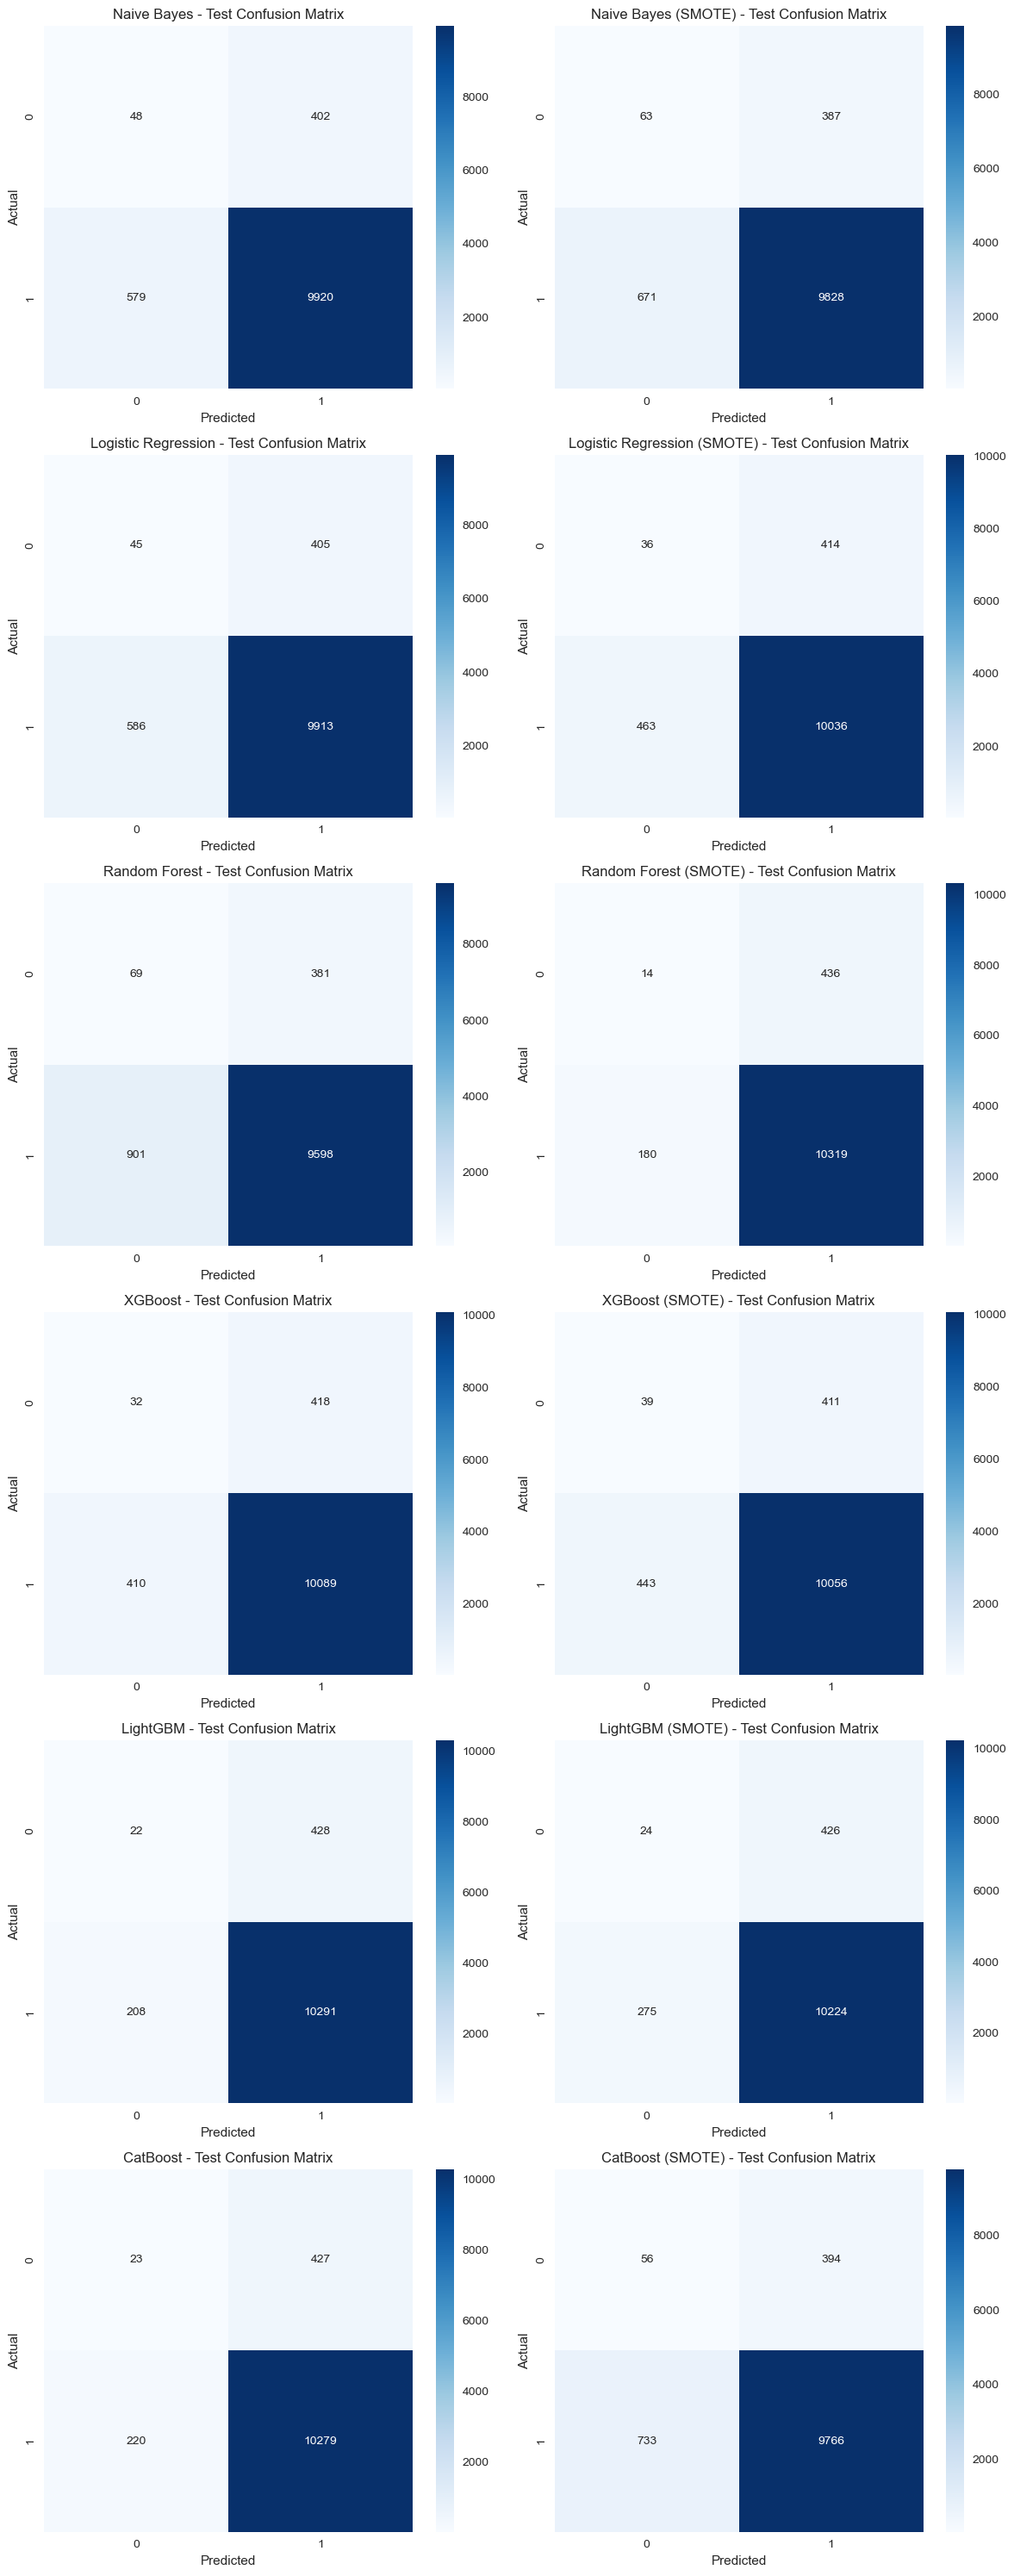

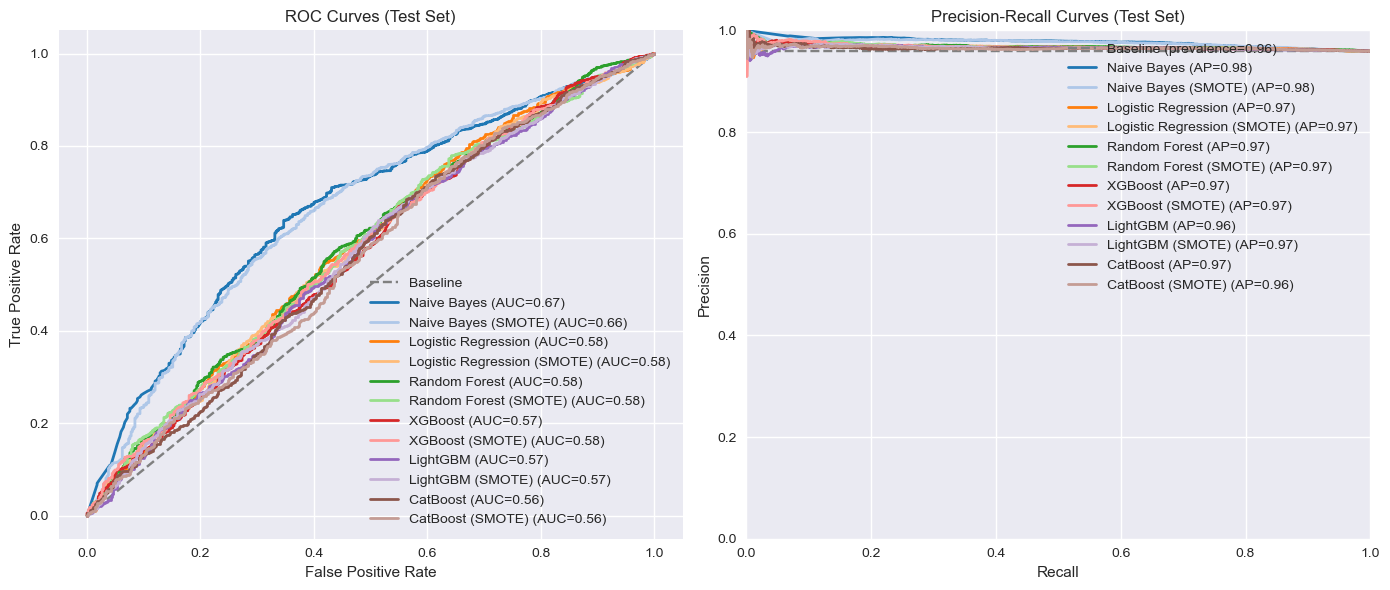

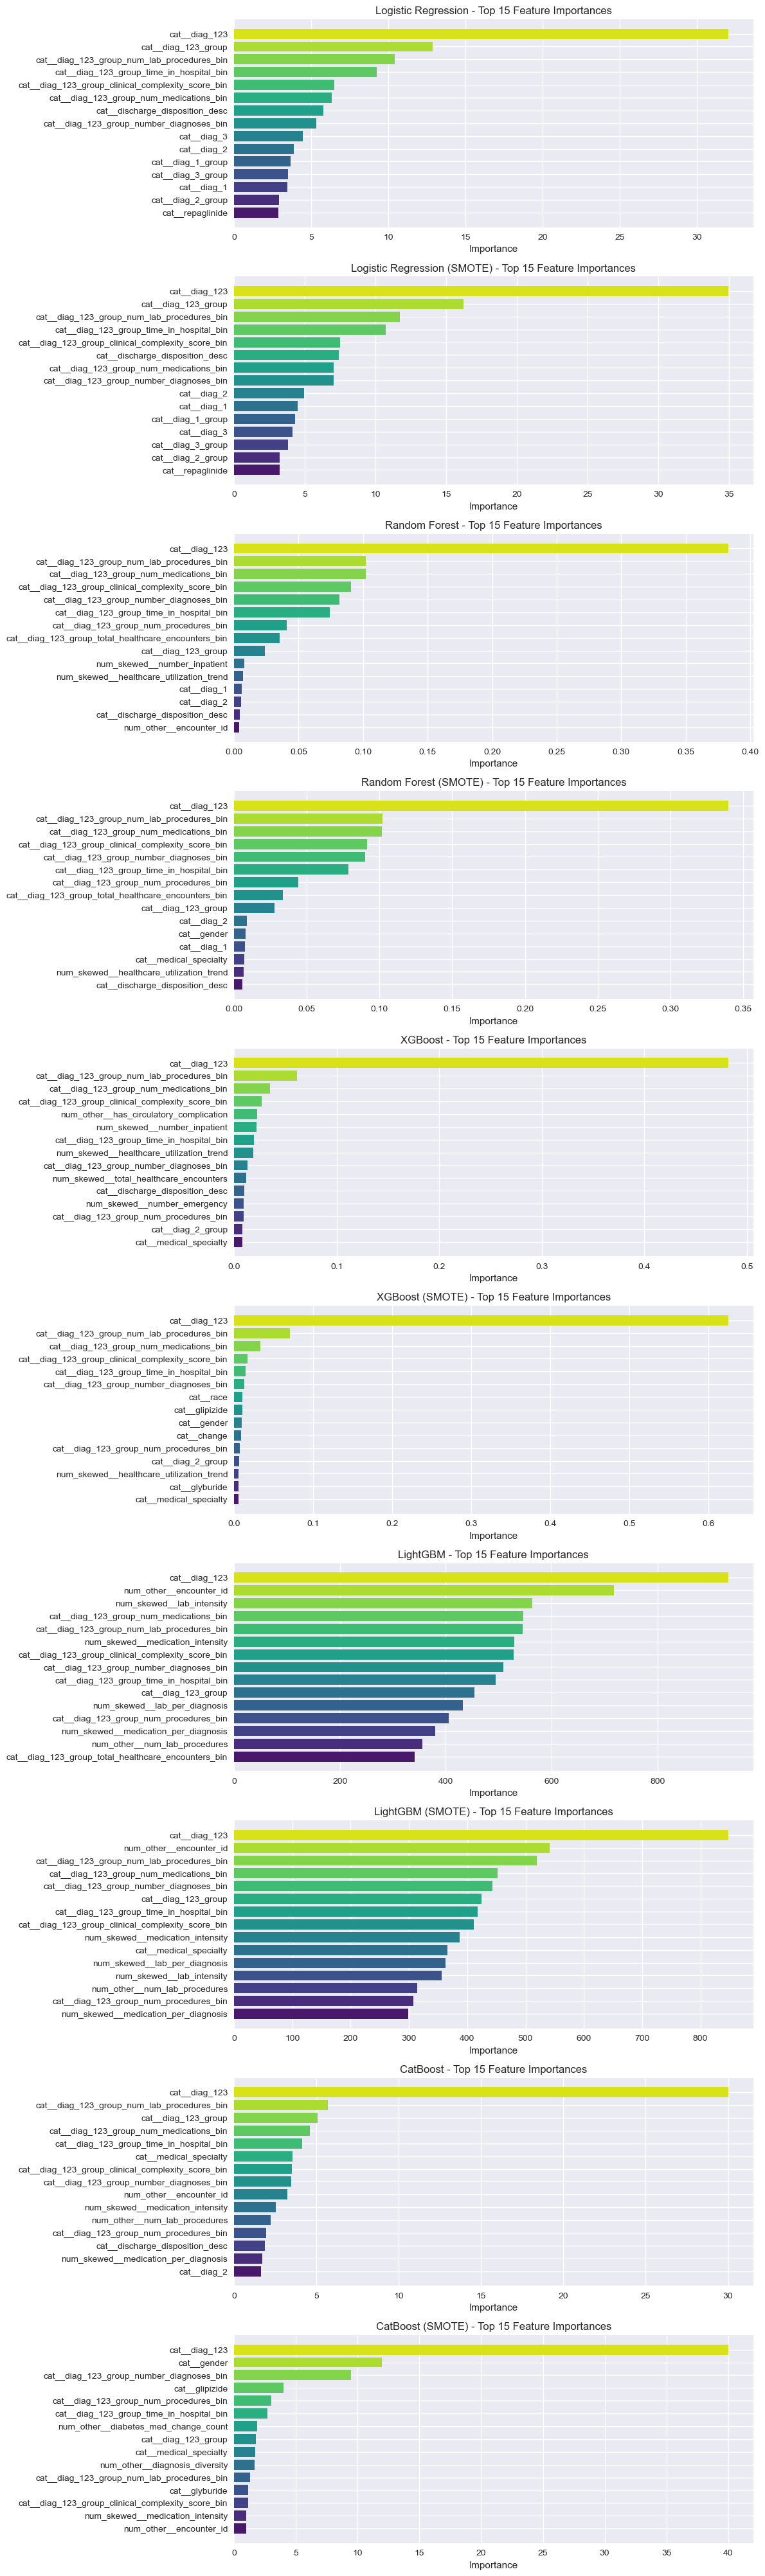

Detected model type: RandomForestClassifier
Using TreeExplainer for tree-based model
Using class 1 SHAP values for binary classification
SHAP contribution summary for ALL features (RandomForestClassifier, test set):
Top 20 most important features:
Using class 1 SHAP values for binary classification
SHAP contribution summary for ALL features (RandomForestClassifier, test set):
Top 20 most important features:


mean_abs_shap  mean_shap  \
cat__diag_123                                            0.153548   0.137052   
cat__diag_123_group_num_lab_procedures_bin               0.066454   0.047564   
cat__diag_123_group_time_in_hospital_bin                 0.054658   0.038720   
cat__diag_123_group_num_medications_bin                  0.053901   0.037675   
cat__diag_123_group_clinical_complexity_score_bin        0.053640   0.034134   
cat__diag_123_group_number_diagnoses_bin                 0.052266   0.032166   
cat__diag_123_group_num_procedures_bin                   0.035718   0.028033   
cat__diag_123_group_total_healthcare_encounters...       0.016169   0.011080   
cat__medical_specialty                                   0.009716   0.003811   
cat__diag_1                                              0.005425   0.002868   
cat__gender                                              0.005075   0.005069   
cat__diag_2                                              0.005036   0.002277   
cat__age                                                 0.004947   0.001929   
cat__discharge_disposition_desc                          0.004608   0.002359   
cat__diag_123_group                                      0.004133   0.002323   
cat__race                                                0.004065   0.002459   
num_skewed__healthcare_utilization_trend                 0.003829   0.002077   
cat__diag_3                                              0.002988   0.001507   
num_skewed__number_inpatient                             0.002837   0.001635   
num_skewed__total_healthcare_encounters                  0.002781   0.001191   

                                                    feature_mean  
cat__diag_123                                           0.965224  
cat__diag_123_group_num_lab_procedures_bin              0.966731  
cat__diag_123_group_time_in_hospital_bin                0.967165  
cat__diag_123_group_num_medications_bin                 0.968255  
cat__diag_123_group_clinical_complexity_score_bin       0.967540  
cat__diag_123_group_number_diagnoses_bin                0.967248  
cat__diag_123_group_num_procedures_bin                  0.966997  
cat__diag_123_group_total_healthcare_encounters...      0.966153  
cat__medical_specialty                                  0.960768  
cat__diag_1                                             0.961317  
cat__gender                                             0.960813  
cat__diag_2                                             0.961289  
cat__age                                                0.960790  
cat__discharge_disposition_desc                         0.960960  
cat__diag_123_group                                     0.964118  
cat__race                                               0.960766  
num_skewed__healthcare_utilization_trend                0.013114  
cat__diag_3                                             0.961169  
num_skewed__number_inpatient                            0.002592  
num_skewed__total_healthcare_encounters                 0.018004

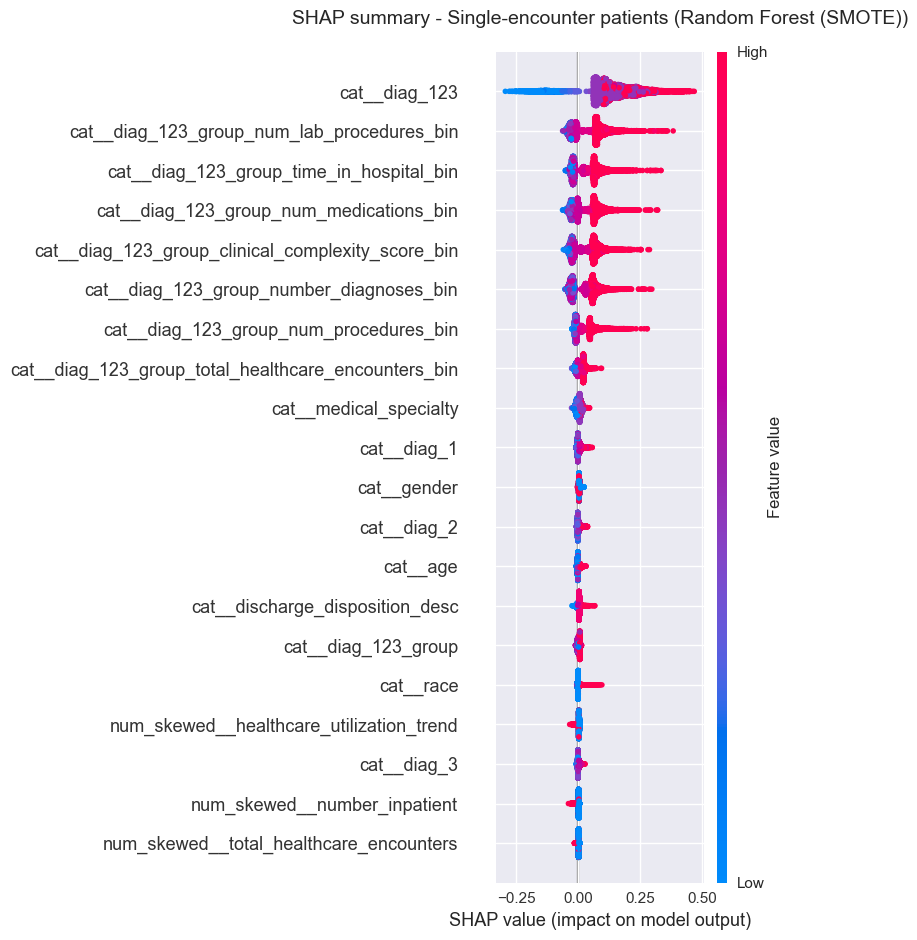

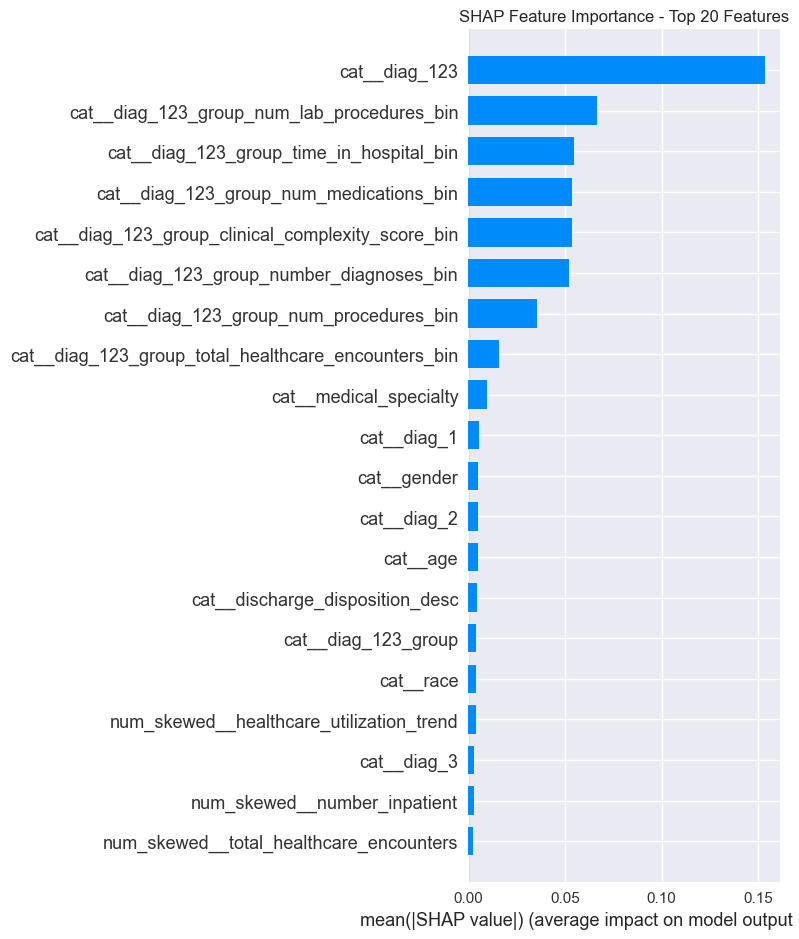

======================================== RETURNING PATIENTS GROUP PIPELINE ========================================
Creating patient history features (avoiding temporal leakage)...
Creating patient history features (avoiding temporal leakage)...
✓ Created 30 patient history features without data leakage
  - All features use only PRIOR encounters (via .shift(1))
  - First encounter for each patient has 0/NaN values (no prior history)
  - Uses readmitted_binary (30-day readmission) as target-aligned feature
  - Added 9 NEW advanced features for improved F1 score
  - Sample new features: has_diabetes_meds, healthcare_utilization_trend, high_confidence_readmission, high_risk_med_combo, historic_unique_diag_groups, is_returning_patient, log_num_procedures, log_prior_encounter_count, low_risk_profile, medication_count_change

=== Leakage Check ===
First encounters: 16755
Prior 30-day readmission count for first encounters (should be 0): 0.0
Prior any readmission count for first encounters (s

mutual_information
cat__diag_123                                                 0.351141
cat__diag_123_group_num_lab_procedures_bin                    0.132204
cat__diag_123_group_time_in_hospital_bin                      0.131128
cat__diag_123_group_num_medications_bin                       0.131036
cat__diag_123_group_clinical_complexity_score_bin             0.128846
cat__diag_123_group_total_healthcare_encounters...            0.110317
cat__diag_123_group_prior_avg_num_medications_bin             0.104825
cat__diag_123_group_prior_avg_num_lab_procedure...            0.104570
cat__diag_123_group_prior_avg_time_in_hospital_bin            0.104487
cat__diag_123_group_prior_encounter_count_bin                 0.098538

PCA retained 60 components covering 95.18% variance and 83 original numeric features (>= 95% contribution).


pca_weighted_contribution
num_skewed__prior_total_emergency                         0.013819
num_other__inpatient_ratio                                0.013691
num_skewed__prior_total_outpatient                        0.013636
num_skewed__current_vs_avg_procedures                     0.013402
num_other__high_confidence_readmission                    0.013387
num_other__hospitalization_escalation                     0.013298
num_skewed__prior_total_inpatient                         0.013258
num_skewed__total_healthcare_encounters                   0.013199
num_other__medication_escalation                          0.013147
num_skewed__current_vs_avg_medications                    0.013117

Top 10 features by Random Forest importance:


rf_importance
cat__diag_123                                            0.364535
cat__diag_123_group_num_lab_procedures_bin               0.059442
cat__diag_123_group_time_in_hospital_bin                 0.058998
cat__diag_123_group_num_medications_bin                  0.053607
cat__diag_123_group_clinical_complexity_score_bin        0.051879
cat__diag_123_group_total_healthcare_encounters...       0.036030
cat__diag_123_group_prior_avg_num_medications_bin        0.028491
cat__diag_123_group_prior_avg_num_lab_procedure...       0.028071
cat__diag_123_group_prior_avg_time_in_hospital_bin       0.026417
cat__diag_123_group_number_diagnoses_bin                 0.022099

Feature selection summary:
  • Correlated features removed: 34
  • Features considered after decorrelation: 90
  • Selected features after voting (>=1 vote): 79
  • Final feature shapes (train/test): (37697, 79), (9262, 79)
Class imbalance ratio (neg:pos): 0.25:1
Detected class imbalance (minority ratio=0.197 < threshold=0.35). Evaluating baseline and SMOTE variants.
Numeric feature groups for preprocessing:
  • Total numeric columns: 85
  • Skew-corrected columns (> 1.0 skew & non-binary): 32
  • Remaining numeric columns: 53
Numeric feature groups for preprocessing:
  • Total numeric columns: 85
  • Skew-corrected columns (> 1.0 skew & non-binary): 32
  • Remaining numeric columns: 53
Encoded feature counts:
  • Train: (30382, 124)
  • Test: (7315, 124)
Encoded feature counts:
  • Train: (30382, 124)
  • Test: (7315, 124)
Numeric feature groups for preprocessing:
  • Total numeric columns: 85
  • Skew-corrected columns (> 1.0 skew & non-binary): 32
  • Remaining numeric columns: 53
N

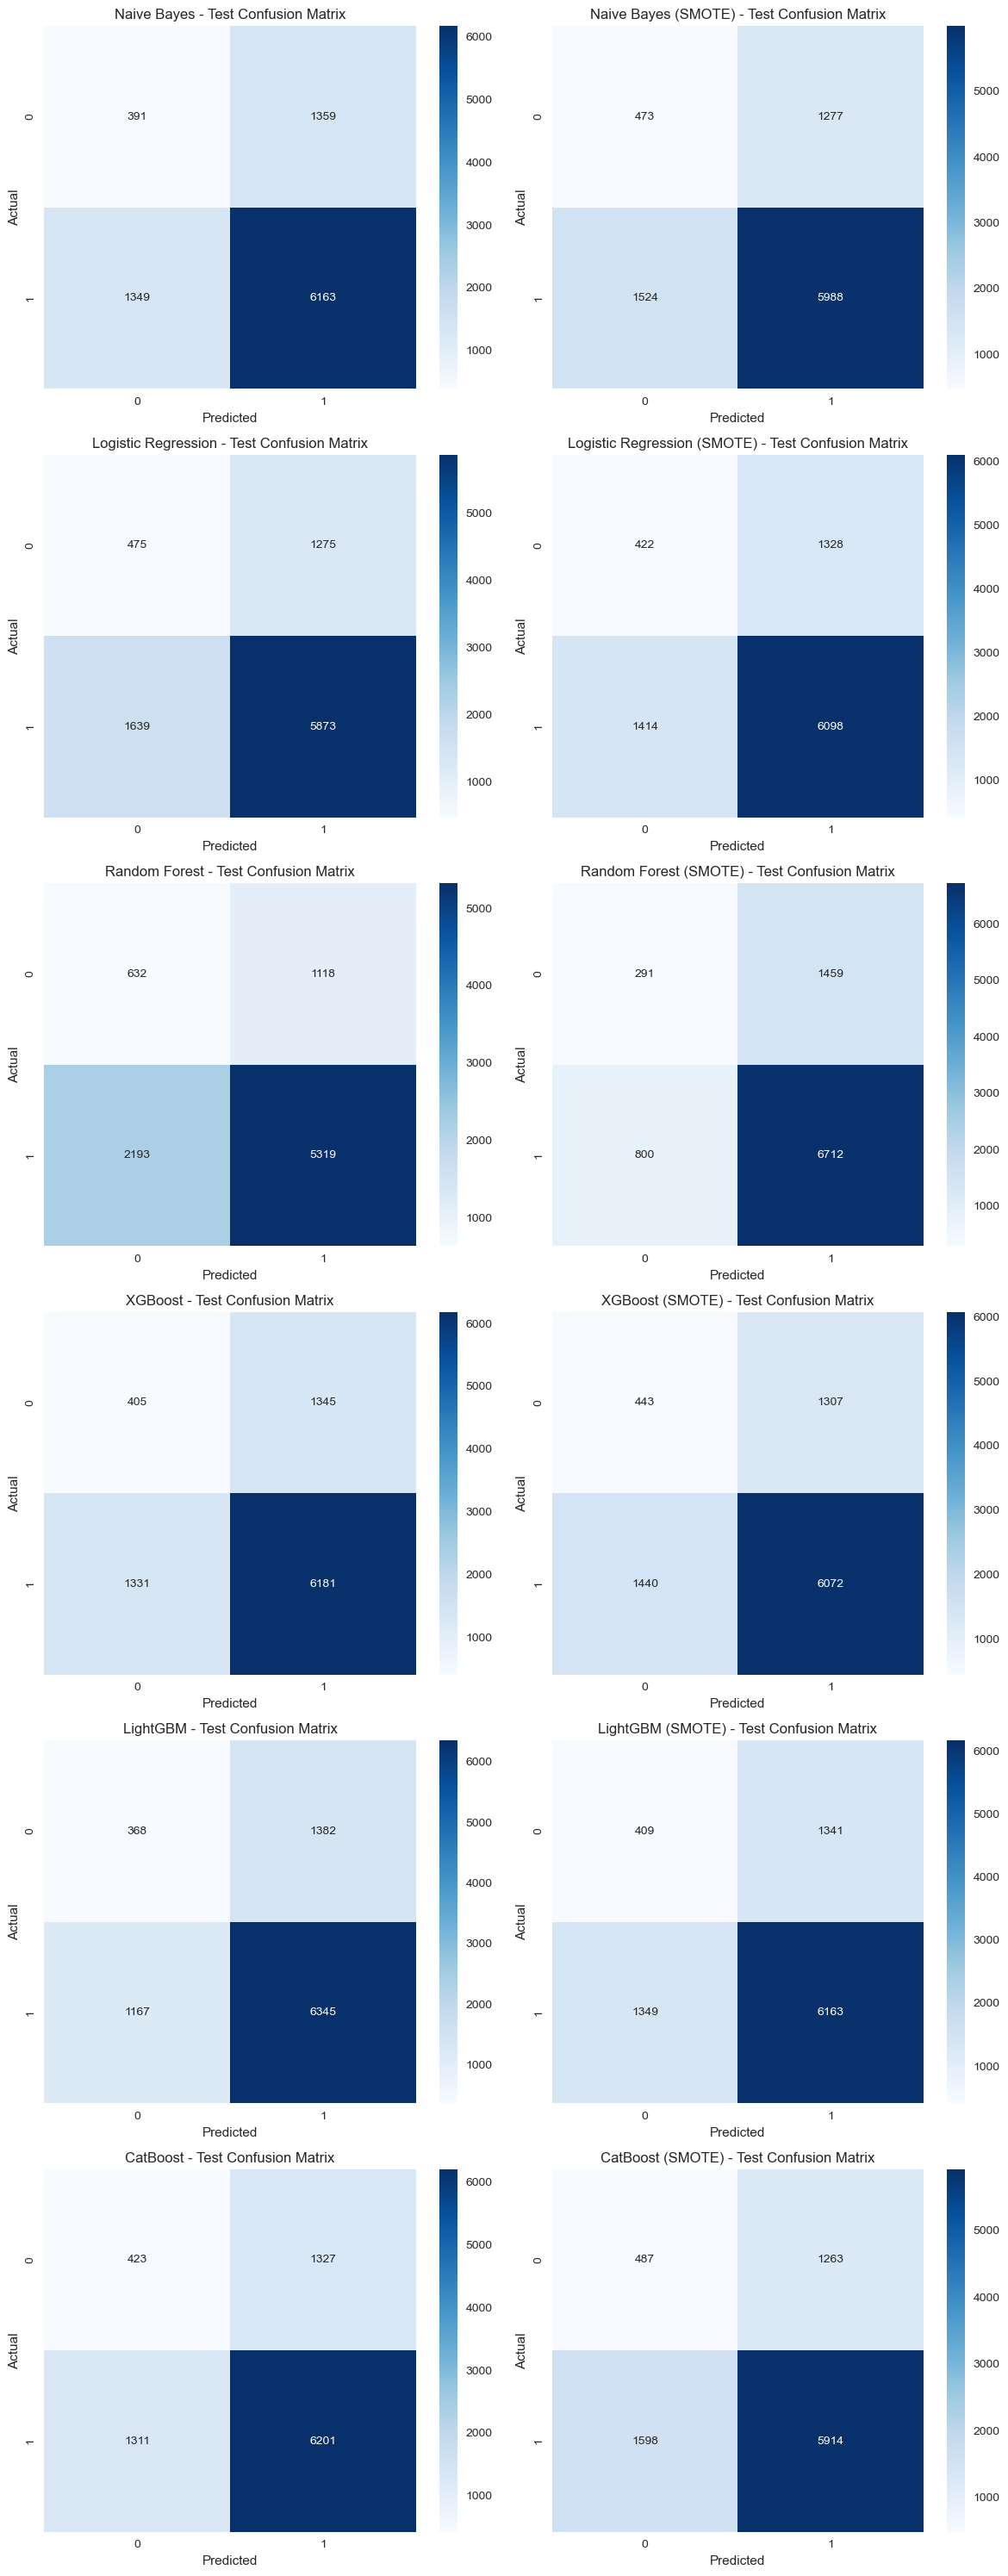

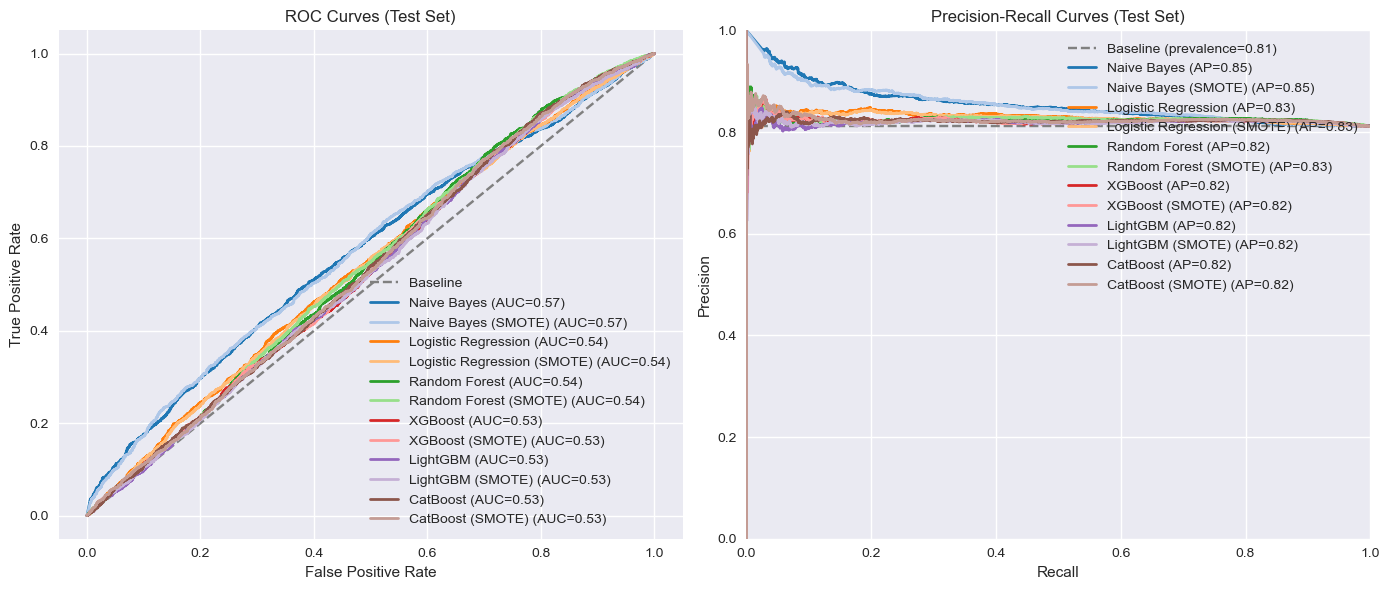

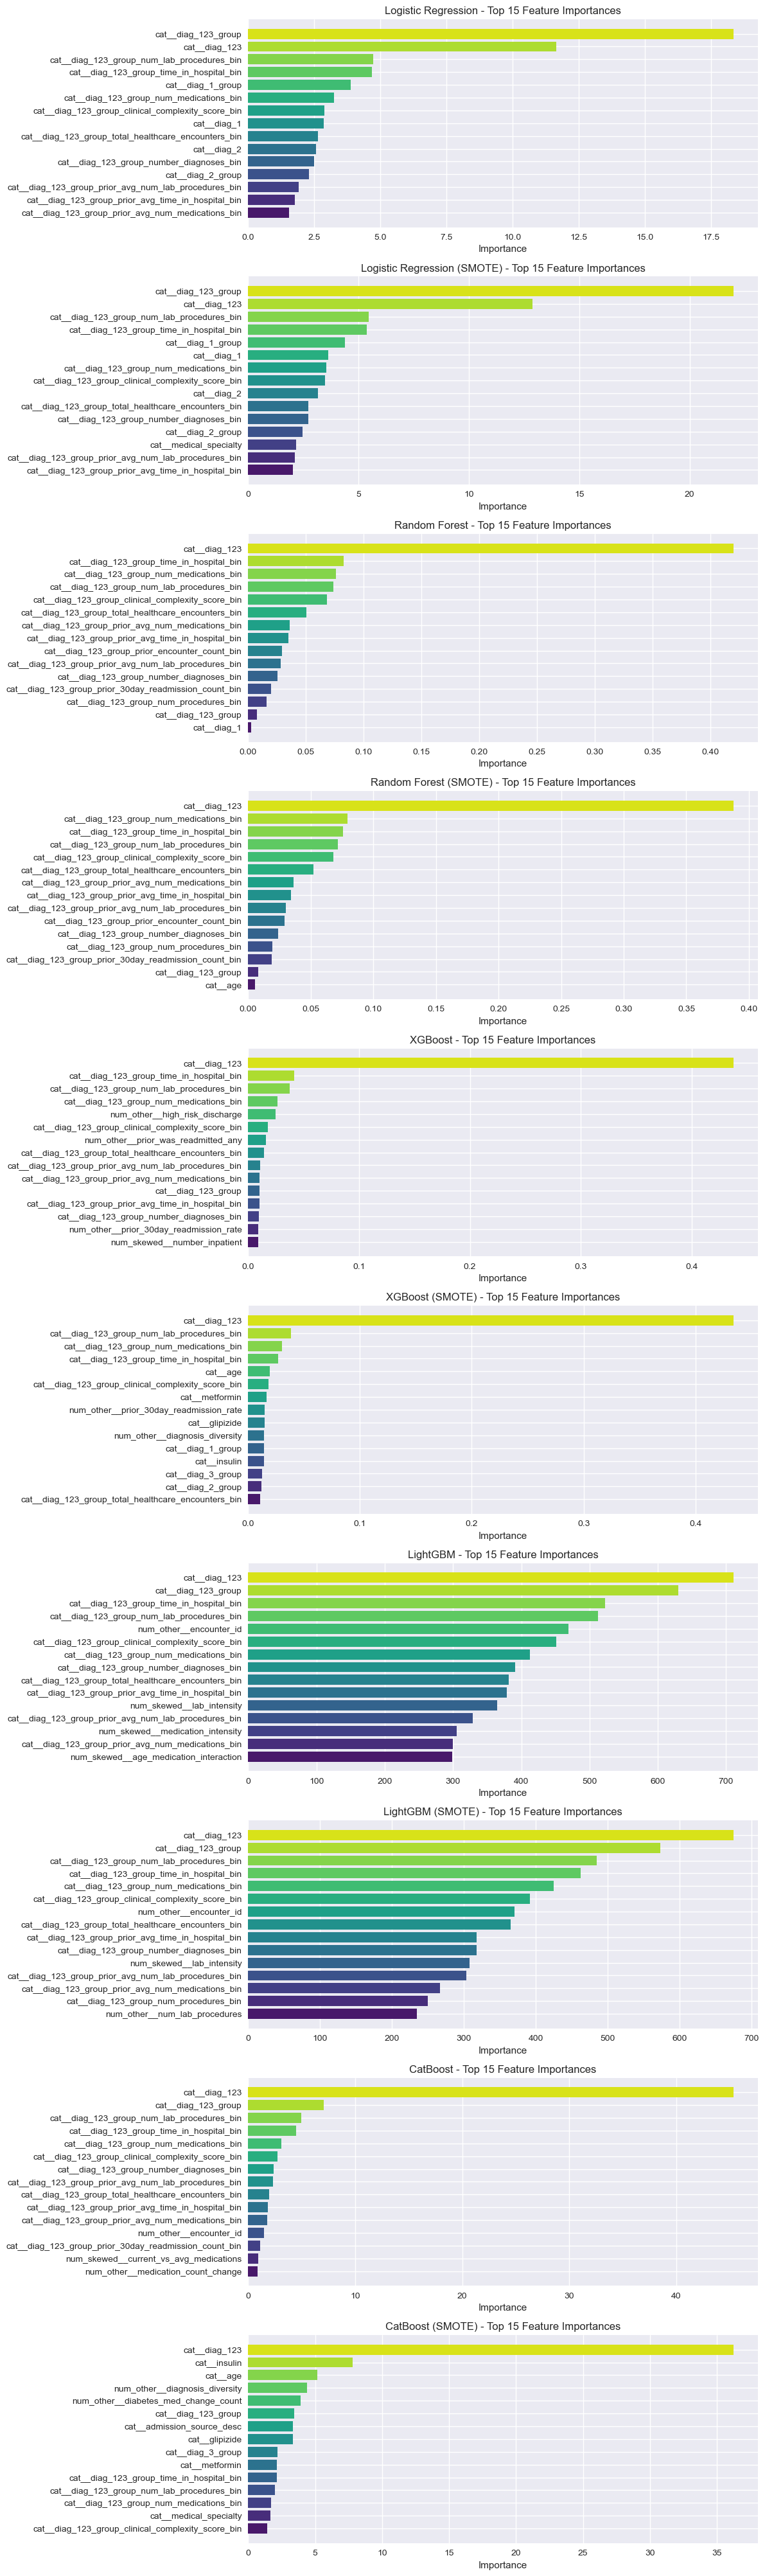

Detected model type: RandomForestClassifier
Using TreeExplainer for tree-based model
Using class 1 SHAP values for binary classification
SHAP contribution summary for ALL features (RandomForestClassifier, test set):
Top 20 most important features:
Using class 1 SHAP values for binary classification
SHAP contribution summary for ALL features (RandomForestClassifier, test set):
Top 20 most important features:


mean_abs_shap  mean_shap  \
cat__diag_123                                            0.138587   0.103381   
cat__diag_123_group_num_lab_procedures_bin               0.043451   0.018177   
cat__diag_123_group_time_in_hospital_bin                 0.042131   0.018401   
cat__diag_123_group_num_medications_bin                  0.041128   0.019703   
cat__diag_123_group_clinical_complexity_score_bin        0.037531   0.014686   
cat__diag_123_group_total_healthcare_encounters...       0.032068   0.012725   
cat__diag_123_group_prior_avg_num_medications_bin        0.024110   0.008990   
cat__diag_123_group_prior_avg_time_in_hospital_bin       0.020073   0.008705   
cat__diag_123_group_prior_avg_num_lab_procedure...       0.019685   0.007600   
cat__diag_123_group_prior_encounter_count_bin            0.017014   0.007111   
cat__diag_123_group_number_diagnoses_bin                 0.013155   0.006037   
cat__diag_123_group_prior_30day_readmission_cou...       0.012962   0.004686   
cat__diag_123_group_num_procedures_bin                   0.009901   0.005139   
num_other__prior_30day_readmission_rate                  0.006216   0.001290   
cat__diag_123_group                                      0.005111   0.000233   
cat__age                                                 0.004749   0.002253   
cat__diag_1_group                                        0.004647   0.000937   
cat__diag_3_group                                        0.003751   0.001605   
cat__diag_3                                              0.002853   0.000588   
num_other__diagnosis_diversity                           0.002771   0.001584   

                                                    feature_mean  
cat__diag_123                                           0.813107  
cat__diag_123_group_num_lab_procedures_bin              0.811243  
cat__diag_123_group_time_in_hospital_bin                0.811589  
cat__diag_123_group_num_medications_bin                 0.811035  
cat__diag_123_group_clinical_complexity_score_bin       0.811048  
cat__diag_123_group_total_healthcare_encounters...      0.811879  
cat__diag_123_group_prior_avg_num_medications_bin       0.810969  
cat__diag_123_group_prior_avg_time_in_hospital_bin      0.814084  
cat__diag_123_group_prior_avg_num_lab_procedure...      0.810181  
cat__diag_123_group_prior_encounter_count_bin           0.810251  
cat__diag_123_group_number_diagnoses_bin                0.809952  
cat__diag_123_group_prior_30day_readmission_cou...      0.809641  
cat__diag_123_group_num_procedures_bin                  0.809271  
num_other__prior_30day_readmission_rate                 0.005974  
cat__diag_123_group                                     0.807922  
cat__age                                                0.803031  
cat__diag_1_group                                       0.802848  
cat__diag_3_group                                       0.803001  
cat__diag_3                                             0.804071  
num_other__diagnosis_diversity                         -0.002286

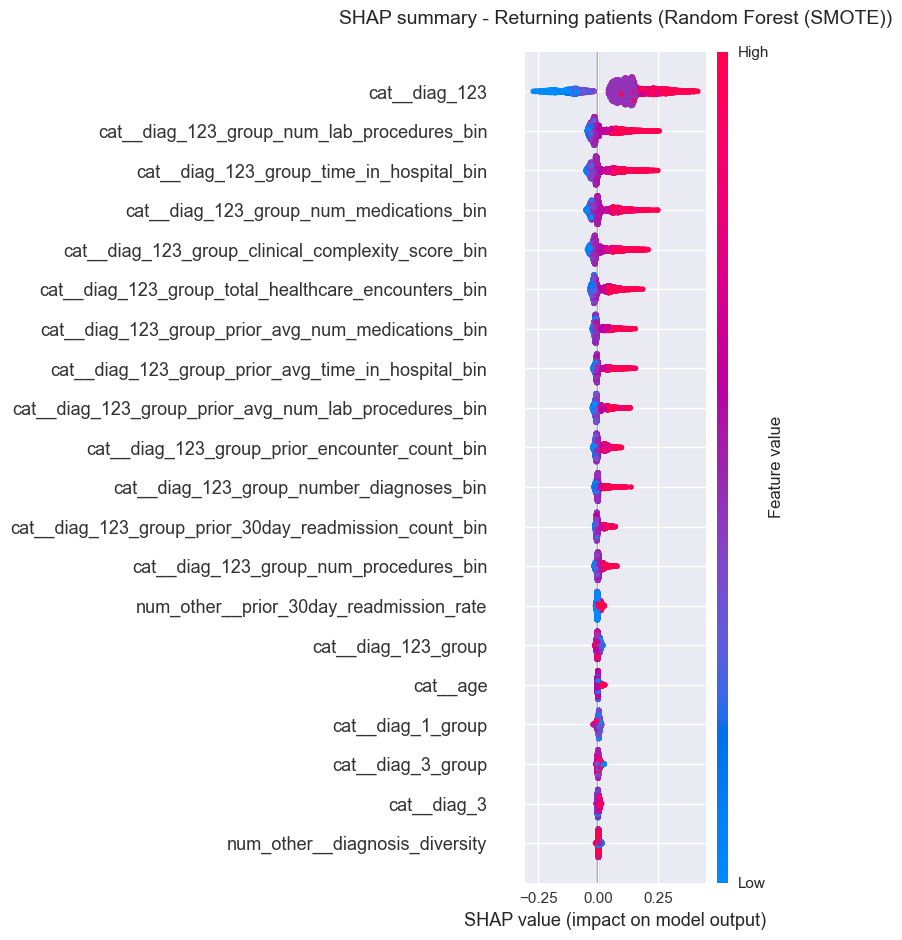

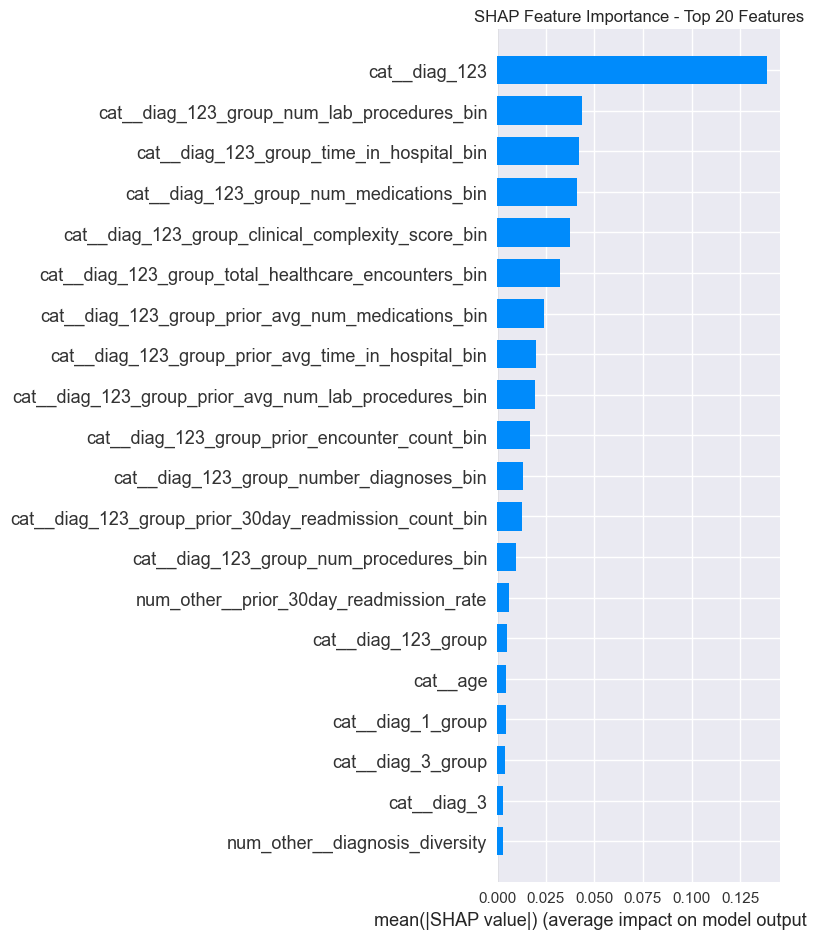

{'Single-encounter patients':                              Val Accuracy (CV)  Val Balanced Acc (CV)  \
 model                                                                   
 Random Forest (SMOTE)                 0.947370               0.506745   
 LightGBM                              0.945315               0.510224   
 CatBoost                              0.942415               0.508055   
 LightGBM (SMOTE)                      0.937049               0.513886   
 XGBoost                               0.929446               0.515663   
 XGBoost (SMOTE)                       0.918394               0.515903   
 Logistic Regression (SMOTE)           0.925085               0.514728   
 Naive Bayes                           0.914810               0.527430   
 Logistic Regression                   0.913599               0.516281   
 Naive Bayes (SMOTE)                   0.906841               0.539674   
 CatBoost (SMOTE)                      0.889670               0.516595   
 Random F

In [128]:
# Split dataset by patient encounter counts (single vs returning)
patient_counts = df.groupby('patient_nbr').size()
single_patient_ids = patient_counts[patient_counts == 1].index
multi_patient_ids = patient_counts[patient_counts > 1].index

group_datasets = {
    'Single-encounter patients': df[df['patient_nbr'].isin(single_patient_ids)].copy(),
    'Returning patients': df[df['patient_nbr'].isin(multi_patient_ids)].copy()
}

for group_name, group_df in group_datasets.items():
    print(f"\n{group_name}: {len(group_df):,} encounters from {group_df['patient_nbr'].nunique():,} patients")
    if group_df.empty:
        print("⚠️  Skipping empty group.")

group_results = {}
for group_name, group_df in group_datasets.items():
    if group_df.empty:
        continue
    group_results[group_name] = run_group_modeling_pipeline(
        group_df,
        group_name=group_name,
        target_col='readmitted_binary',
        test_size=0.2,
        random_state=42,
        shap_sample_size=400
    )

group_summaries = {name: payload['summary'] for name, payload in group_results.items()}
group_summaries

In [129]:
best_model_summary = []
for group, payload in group_results.items():
    best_name = payload['best_model_name']
    best_metrics = payload['results'][best_name]['test']
    best_model_summary.append({
        'group': group,
        'best_model': best_name,
        'precision': best_metrics['precision'],
        'recall': best_metrics['recall'],
        'f1': best_metrics['f1'],
        'roc_auc': best_metrics['roc_auc'],
        'avg_precision': best_metrics['average_precision'],
        'accuracy': best_metrics['accuracy'],
        'balanced_accuracy': best_metrics['balanced_accuracy'],
        'specificity': best_metrics['specificity']
    })
pd.DataFrame(best_model_summary)

group             best_model  precision    recall  \
0  Single-encounter patients  Random Forest (SMOTE)   0.959461  0.982856   
1         Returning patients  Random Forest (SMOTE)   0.821442  0.893504   

         f1   roc_auc  avg_precision  accuracy  balanced_accuracy  specificity  
0  0.971017  0.579189       0.967748  0.943739           0.506983     0.031111  
1  0.855959  0.540589       0.825163  0.756100           0.529895     0.166286

In [130]:
# Performance analysis breakdown by selected features
for group, payload in group_results.items():
    X_test_final = payload['X_test_final']
    y_test = payload['y_test']
    best_estimator = payload['best_model_payload']['estimator']
    test_metadata = df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]    
    print(f'==={group} CONFUSION MATRIX ANALYSIS BY FEATURE===')
    for feature in test_metadata.columns:
        print(f"\nConfusion breakdown by {feature}:")
        display(confusion_breakdown(best_estimator, X_test_final, y_test, test_metadata, feature))

===Single-encounter patients CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support  TN   FP   FN    TP  specificity    recall
3        Caucasian     7946  11  311  121  7503     0.034161  0.984129
1  AfricanAmerican     2407   3   98   47  2259     0.029703  0.979618
4         Hispanic      203   0    8    4   191     0.000000  0.979487
0                ?      194   0    9    1   184     0.000000  0.994595
5            Other      153   0    6    5   142     0.000000  0.965986
2            Asian       46   0    4    2    40     0.000000  0.952381


Confusion breakdown by age:


age  support  TN   FP  FN    TP  specificity    recall
7   [70-80)     2905   6  112  52  2735     0.050847  0.981342
6   [60-70)     2395   2   85  49  2259     0.022989  0.978769
5   [50-60)     2006   4   89  24  1889     0.043011  0.987454
8   [80-90)     1337   1   52  17  1267     0.018868  0.986760
4   [40-50)     1177   1   45  18  1113     0.021739  0.984085
3   [30-40)      492   0   22   7   463     0.000000  0.985106
9  [90-100)      192   0   12   1   179     0.000000  0.994444
1   [10-20)      190   0    8   5   177     0.000000  0.972527
2   [20-30)      184   0    9   4   171     0.000000  0.977143
0    [0-10)       71   0    2   3    66     0.000000  0.956522


Confusion breakdown by diag_1_group:


diag_1_group  support  TN   FP  FN  \
0                                         Circulatory     3947   4  135  69   
10                                        Respiratory     1267   2   59  21   
1                                            Diabetes     1061   1   45  21   
2                                           Digestive      904   2   44  10   
6                                              Injury      696   1   24  10   
7                                     Musculoskeletal      473   1   21   9   
4                                       Genitourinary      447   1   18   6   
8                                           Neoplasms      384   0   16   5   
17        symptoms, signs, and ill-defined conditions      309   1   10   8   
16                                   mental disorders      305   0   14   6   
3   Endocrine, nutritional and metabolic diseases,...      228   0    9   7   
15       diseases of the skin and subcutaneous tissue      220   0    7   2   
5                   Infectious and parasitic diseases      201   0    5   1   
9                                               Other      187   1   10   1   
14    diseases of the nervous system and sense organs      112   0    5   1   
11  complications of pregnancy, childbirth, and th...      107   0    6   2   
13     diseases of the blood and blood-forming organs       97   0    8   1   
12                               congenital anomalies        4   0    0   0   

      TP  specificity    recall  
0   3739     0.028777  0.981880  
10  1185     0.032787  0.982587  
1    994     0.021739  0.979310  
2    848     0.043478  0.988345  
6    661     0.040000  0.985097  
7    442     0.045455  0.980044  
4    422     0.052632  0.985981  
8    363     0.000000  0.986413  
17   290     0.090909  0.973154  
16   285     0.000000  0.979381  
3    212     0.000000  0.968037  
15   211     0.000000  0.990610  
5    195     0.000000  0.994898  
9    175     0.090909  0.994318  
14   106     0.000000  0.990654  
11    99     0.000000  0.980198  
13    88     0.000000  0.988764  
12     4          NaN  1.000000


Confusion breakdown by diag_2_group:


diag_2_group  support  TN   FP  FN  \
0                                         Circulatory     3625   7  130  58   
1                                            Diabetes     2039   1   78  38   
10                                        Respiratory      994   2   37  14   
3   Endocrine, nutritional and metabolic diseases,...      792   0   38  18   
4                                       Genitourinary      620   0   35  11   
2                                           Digestive      413   0   15   8   
9                                               Other      333   0   14   7   
15       diseases of the skin and subcutaneous tissue      319   1   10   0   
8                                           Neoplasms      280   0   12   5   
13     diseases of the blood and blood-forming organs      269   1   17   2   
17        symptoms, signs, and ill-defined conditions      269   0   13   3   
16                                   mental disorders      258   0    5   3   
6                                              Injury      241   1   10   1   
5                   Infectious and parasitic diseases      202   1    5   8   
7                                     Musculoskeletal      132   0    7   3   
14    diseases of the nervous system and sense organs       95   0    4   1   
11  complications of pregnancy, childbirth, and th...       60   0    5   0   
12                               congenital anomalies        8   0    1   0   

      TP  specificity    recall  
0   3430     0.051095  0.983372  
1   1922     0.012658  0.980612  
10   941     0.051282  0.985340  
3    736     0.000000  0.976127  
4    574     0.000000  0.981197  
2    390     0.000000  0.979899  
9    312     0.000000  0.978056  
15   308     0.090909  1.000000  
8    263     0.000000  0.981343  
13   249     0.055556  0.992032  
17   253     0.000000  0.988281  
16   250     0.000000  0.988142  
6    229     0.090909  0.995652  
5    188     0.166667  0.959184  
7    122     0.000000  0.976000  
14    90     0.000000  0.989011  
11    55     0.000000  1.000000  
12     7     0.000000  1.000000


Confusion breakdown by diag_3_group:


diag_3_group  support  TN   FP  FN  \
0                                         Circulatory     3317   5  125  49   
1                                            Diabetes     2211   3   88  34   
3   Endocrine, nutritional and metabolic diseases,...      843   1   29  15   
9                                               Other      805   2   28  17   
10                                        Respiratory      708   0   27  11   
4                                       Genitourinary      570   0   21   8   
2                                           Digestive      404   1   21  11   
16                                   mental disorders      342   0   18   4   
17        symptoms, signs, and ill-defined conditions      251   0   17   6   
13     diseases of the blood and blood-forming organs      227   1    9   5   
5                   Infectious and parasitic diseases      225   0   10   5   
15       diseases of the skin and subcutaneous tissue      220   0    9   2   
14    diseases of the nervous system and sense organs      214   0    8   2   
6                                              Injury      193   0    9   4   
8                                           Neoplasms      180   0    6   4   
7                                     Musculoskeletal      177   1    9   3   
11  complications of pregnancy, childbirth, and th...       53   0    2   0   
12                               congenital anomalies        9   0    0   0   

      TP  specificity    recall  
0   3138     0.038462  0.984625  
1   2086     0.032967  0.983962  
3    798     0.033333  0.981550  
9    758     0.066667  0.978065  
10   670     0.000000  0.983847  
4    541     0.000000  0.985428  
2    371     0.045455  0.971204  
16   320     0.000000  0.987654  
17   228     0.000000  0.974359  
13   212     0.100000  0.976959  
5    210     0.000000  0.976744  
15   209     0.000000  0.990521  
14   204     0.000000  0.990291  
6    180     0.000000  0.978261  
8    170     0.000000  0.977011  
7    164     0.100000  0.982036  
11    51     0.000000  1.000000  
12     9          NaN  1.000000

===Returning patients CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support   TN    FP   FN    TP  specificity    recall
3        Caucasian     6690  203  1046  573  4868     0.162530  0.894688
1  AfricanAmerican     2059   70   322  186  1481     0.178571  0.888422
0                ?      172    5    38   13   116     0.116279  0.899225
4         Hispanic      168    7    28   11   122     0.200000  0.917293
5            Other      132    6    18   12    96     0.250000  0.888889
2            Asian       41    0     7    5    29     0.000000  0.852941


Confusion breakdown by age:


age  support  TN   FP   FN    TP  specificity    recall
7   [70-80)     2456  81  376  236  1763     0.177243  0.881941
6   [60-70)     2000  59  320  166  1455     0.155673  0.897594
5   [50-60)     1716  41  255  145  1275     0.138514  0.897887
8   [80-90)     1145  43  186   84   832     0.187773  0.908297
4   [40-50)      999  31  177   89   702     0.149038  0.887484
3   [30-40)      411  19   66   28   298     0.223529  0.914110
9  [90-100)      164   6   23   19   116     0.206897  0.859259
1   [10-20)      162   4   25   13   120     0.137931  0.902256
2   [20-30)      144   7   24   17    96     0.225806  0.849558
0    [0-10)       65   0    7    3    55     0.000000  0.948276


Confusion breakdown by diag_1_group:


diag_1_group  support   TN   FP   FN  \
0                                         Circulatory     3345  108  554  283   
10                                        Respiratory     1073   31  156  104   
1                                            Diabetes      914   27  144   83   
2                                           Digestive      749   24  112   63   
6                                              Injury      588   16   91   45   
7                                     Musculoskeletal      394    9   56   23   
4                                       Genitourinary      382   17   60   41   
8                                           Neoplasms      333   10   53   31   
16                                   mental disorders      254    7   41   21   
17        symptoms, signs, and ill-defined conditions      250    6   32   22   
3   Endocrine, nutritional and metabolic diseases,...      186    5   35   17   
15       diseases of the skin and subcutaneous tissue      182    5   34   15   
5                   Infectious and parasitic diseases      179   11   22   22   
9                                               Other      156    3   28    9   
14    diseases of the nervous system and sense organs      101    2   16    7   
11  complications of pregnancy, childbirth, and th...       93    8   10    5   
13     diseases of the blood and blood-forming organs       80    2   14    8   
12                               congenital anomalies        3    0    1    1   

      TP  specificity    recall  
0   2400     0.163142  0.894521  
10   782     0.165775  0.882619  
1    660     0.157895  0.888291  
2    550     0.176471  0.897227  
6    436     0.149533  0.906445  
7    306     0.138462  0.930091  
4    264     0.220779  0.865574  
8    239     0.158730  0.885185  
16   185     0.145833  0.898058  
17   190     0.157895  0.896226  
3    129     0.125000  0.883562  
15   128     0.128205  0.895105  
5    124     0.333333  0.849315  
9    116     0.096774  0.928000  
14    76     0.111111  0.915663  
11    70     0.444444  0.933333  
13    56     0.125000  0.875000  
12     1     0.000000  0.500000


Confusion breakdown by diag_2_group:


diag_2_group  support  TN   FP   FN  \
0                                         Circulatory     3081  93  517  279   
1                                            Diabetes     1721  54  270  133   
10                                        Respiratory      834  22  123   63   
3   Endocrine, nutritional and metabolic diseases,...      659  21   93   61   
4                                       Genitourinary      520  22   75   59   
2                                           Digestive      355  12   55   28   
9                                               Other      296   4   49   22   
15       diseases of the skin and subcutaneous tissue      274   8   54   21   
8                                           Neoplasms      244   6   48   24   
13     diseases of the blood and blood-forming organs      228   4   37   24   
16                                   mental disorders      215   4   26   22   
17        symptoms, signs, and ill-defined conditions      210  10   27   11   
6                                              Injury      207   8   31   15   
5                   Infectious and parasitic diseases      171  10   28   18   
7                                     Musculoskeletal      112   4    9    6   
14    diseases of the nervous system and sense organs       80   4   10   10   
11  complications of pregnancy, childbirth, and th...       50   4    7    4   
12                               congenital anomalies        5   1    0    0   

      TP  specificity    recall  
0   2192     0.152459  0.887090  
1   1264     0.166667  0.904796  
10   626     0.151724  0.908563  
3    484     0.184211  0.888073  
4    364     0.226804  0.860520  
2    260     0.179104  0.902778  
9    221     0.075472  0.909465  
15   191     0.129032  0.900943  
8    166     0.111111  0.873684  
13   163     0.097561  0.871658  
16   163     0.133333  0.881081  
17   162     0.270270  0.936416  
6    153     0.205128  0.910714  
5    115     0.263158  0.864662  
7     93     0.307692  0.939394  
14    56     0.285714  0.848485  
11    35     0.363636  0.897436  
12     4     1.000000  1.000000


Confusion breakdown by diag_3_group:


diag_3_group  support  TN   FP   FN  \
0                                         Circulatory     2801  84  423  257   
1                                            Diabetes     1896  63  302  169   
3   Endocrine, nutritional and metabolic diseases,...      696  23  105   71   
9                                               Other      685  26  106   55   
10                                        Respiratory      608  18  104   40   
4                                       Genitourinary      484  18   70   43   
2                                           Digestive      335  10   56   27   
16                                   mental disorders      274   9   46   24   
17        symptoms, signs, and ill-defined conditions      205   5   31   13   
13     diseases of the blood and blood-forming organs      191   3   32   18   
5                   Infectious and parasitic diseases      190   6   35   14   
15       diseases of the skin and subcutaneous tissue      187   7   36   12   
14    diseases of the nervous system and sense organs      179   3   28   17   
6                                              Injury      172   5   24   14   
7                                     Musculoskeletal      156   3   24   16   
8                                           Neoplasms      149   4   28    8   
11  complications of pregnancy, childbirth, and th...       47   4    7    2   
12                               congenital anomalies        7   0    2    0   

      TP  specificity    recall  
0   2037     0.165680  0.887969  
1   1362     0.172603  0.889615  
3    497     0.179688  0.875000  
9    498     0.196970  0.900542  
10   446     0.147541  0.917695  
4    353     0.204545  0.891414  
2    242     0.151515  0.899628  
16   195     0.163636  0.890411  
17   156     0.138889  0.923077  
13   138     0.085714  0.884615  
5    135     0.146341  0.906040  
15   132     0.162791  0.916667  
14   131     0.096774  0.885135  
6    129     0.172414  0.902098  
7    113     0.111111  0.875969  
8    109     0.125000  0.931624  
11    34     0.363636  0.944444  
12     5     0.000000  1.000000

# all df

======================================== ALL PATIENTS GROUP PIPELINE ========================================
Creating patient history features (avoiding temporal leakage)...
Creating patient history features (avoiding temporal leakage)...
✓ Created 30 patient history features without data leakage
  - All features use only PRIOR encounters (via .shift(1))
  - First encounter for each patient has 0/NaN values (no prior history)
  - Uses readmitted_binary (30-day readmission) as target-aligned feature
  - Added 9 NEW advanced features for improved F1 score
  - Sample new features: has_diabetes_meds, healthcare_utilization_trend, high_confidence_readmission, high_risk_med_combo, historic_unique_diag_groups, is_returning_patient, log_num_procedures, log_prior_encounter_count, low_risk_profile, medication_count_change

=== Leakage Check ===
First encounters: 71500
Prior 30-day readmission count for first encounters (should be 0): 0.0
Prior any readmission count for first encounters (should 

mutual_information
cat__diag_123                                                 0.238048
cat__diag_123_group_clinical_complexity_score_bin             0.074187
cat__diag_123_group_time_in_hospital_bin                      0.073318
cat__diag_123_group_num_lab_procedures_bin                    0.072760
cat__diag_123_group_num_medications_bin                       0.072740
cat__diag_123_group_number_diagnoses_bin                      0.057517
cat__diag_123_group_num_procedures_bin                        0.055009
cat__diag_123_group_total_healthcare_encounters...            0.054082
cat__diag_123_group_prior_encounter_count_bin                 0.042024
cat__diag_123_group_prior_avg_time_in_hospital_bin            0.038727

PCA retained 58 components covering 95.37% variance and 79 original numeric features (>= 95% contribution).


pca_weighted_contribution
num_other__number_diagnoses                                  0.014251
num_skewed__prior_total_emergency                            0.014067
num_skewed__prior_total_outpatient                           0.013908
cat__diag_3_group                                            0.013765
num_skewed__total_healthcare_encounters                      0.013639
num_skewed__current_vs_avg_hospitalization                   0.013467
num_skewed__healthcare_utilization_trend                     0.013418
num_other__long_hospital_stay                                0.013417
num_skewed__number_inpatient                                 0.013384
num_other__primary_diabetes                                  0.013214

Top 10 features by Random Forest importance:


rf_importance
cat__diag_123                                            0.373131
cat__diag_123_group_num_lab_procedures_bin               0.065055
cat__diag_123_group_num_medications_bin                  0.059341
cat__diag_123_group_time_in_hospital_bin                 0.056285
cat__diag_123_group_clinical_complexity_score_bin        0.055679
cat__diag_123_group_number_diagnoses_bin                 0.037501
cat__diag_123_group_num_procedures_bin                   0.033814
cat__diag_123_group_total_healthcare_encounters...       0.028186
cat__diag_123_group_prior_encounter_count_bin            0.018272
cat__diag_123_group_prior_avg_time_in_hospital_bin       0.013480

Feature selection summary:
  • Correlated features removed: 39
  • Features considered after decorrelation: 85
  • Selected features after voting (>=1 vote): 82
  • Final feature shapes (train/test): (81350, 82), (20354, 82)
Class imbalance ratio (neg:pos): 0.13:1
Detected class imbalance (minority ratio=0.111 < threshold=0.35). Evaluating baseline and SMOTE variants.
Detected class imbalance (minority ratio=0.111 < threshold=0.35). Evaluating baseline and SMOTE variants.
Numeric feature groups for preprocessing:
  • Total numeric columns: 85
  • Skew-corrected columns (> 1.0 skew & non-binary): 42
  • Remaining numeric columns: 43
Numeric feature groups for preprocessing:
  • Total numeric columns: 85
  • Skew-corrected columns (> 1.0 skew & non-binary): 42
  • Remaining numeric columns: 43
Encoded feature counts:
  • Train: (65246, 124)
  • Test: (16104, 124)
Encoded feature counts:
  • Train: (65246, 124)
  • Test: (16104, 124)
Numeric feature groups for preprocessing:
  • Total num

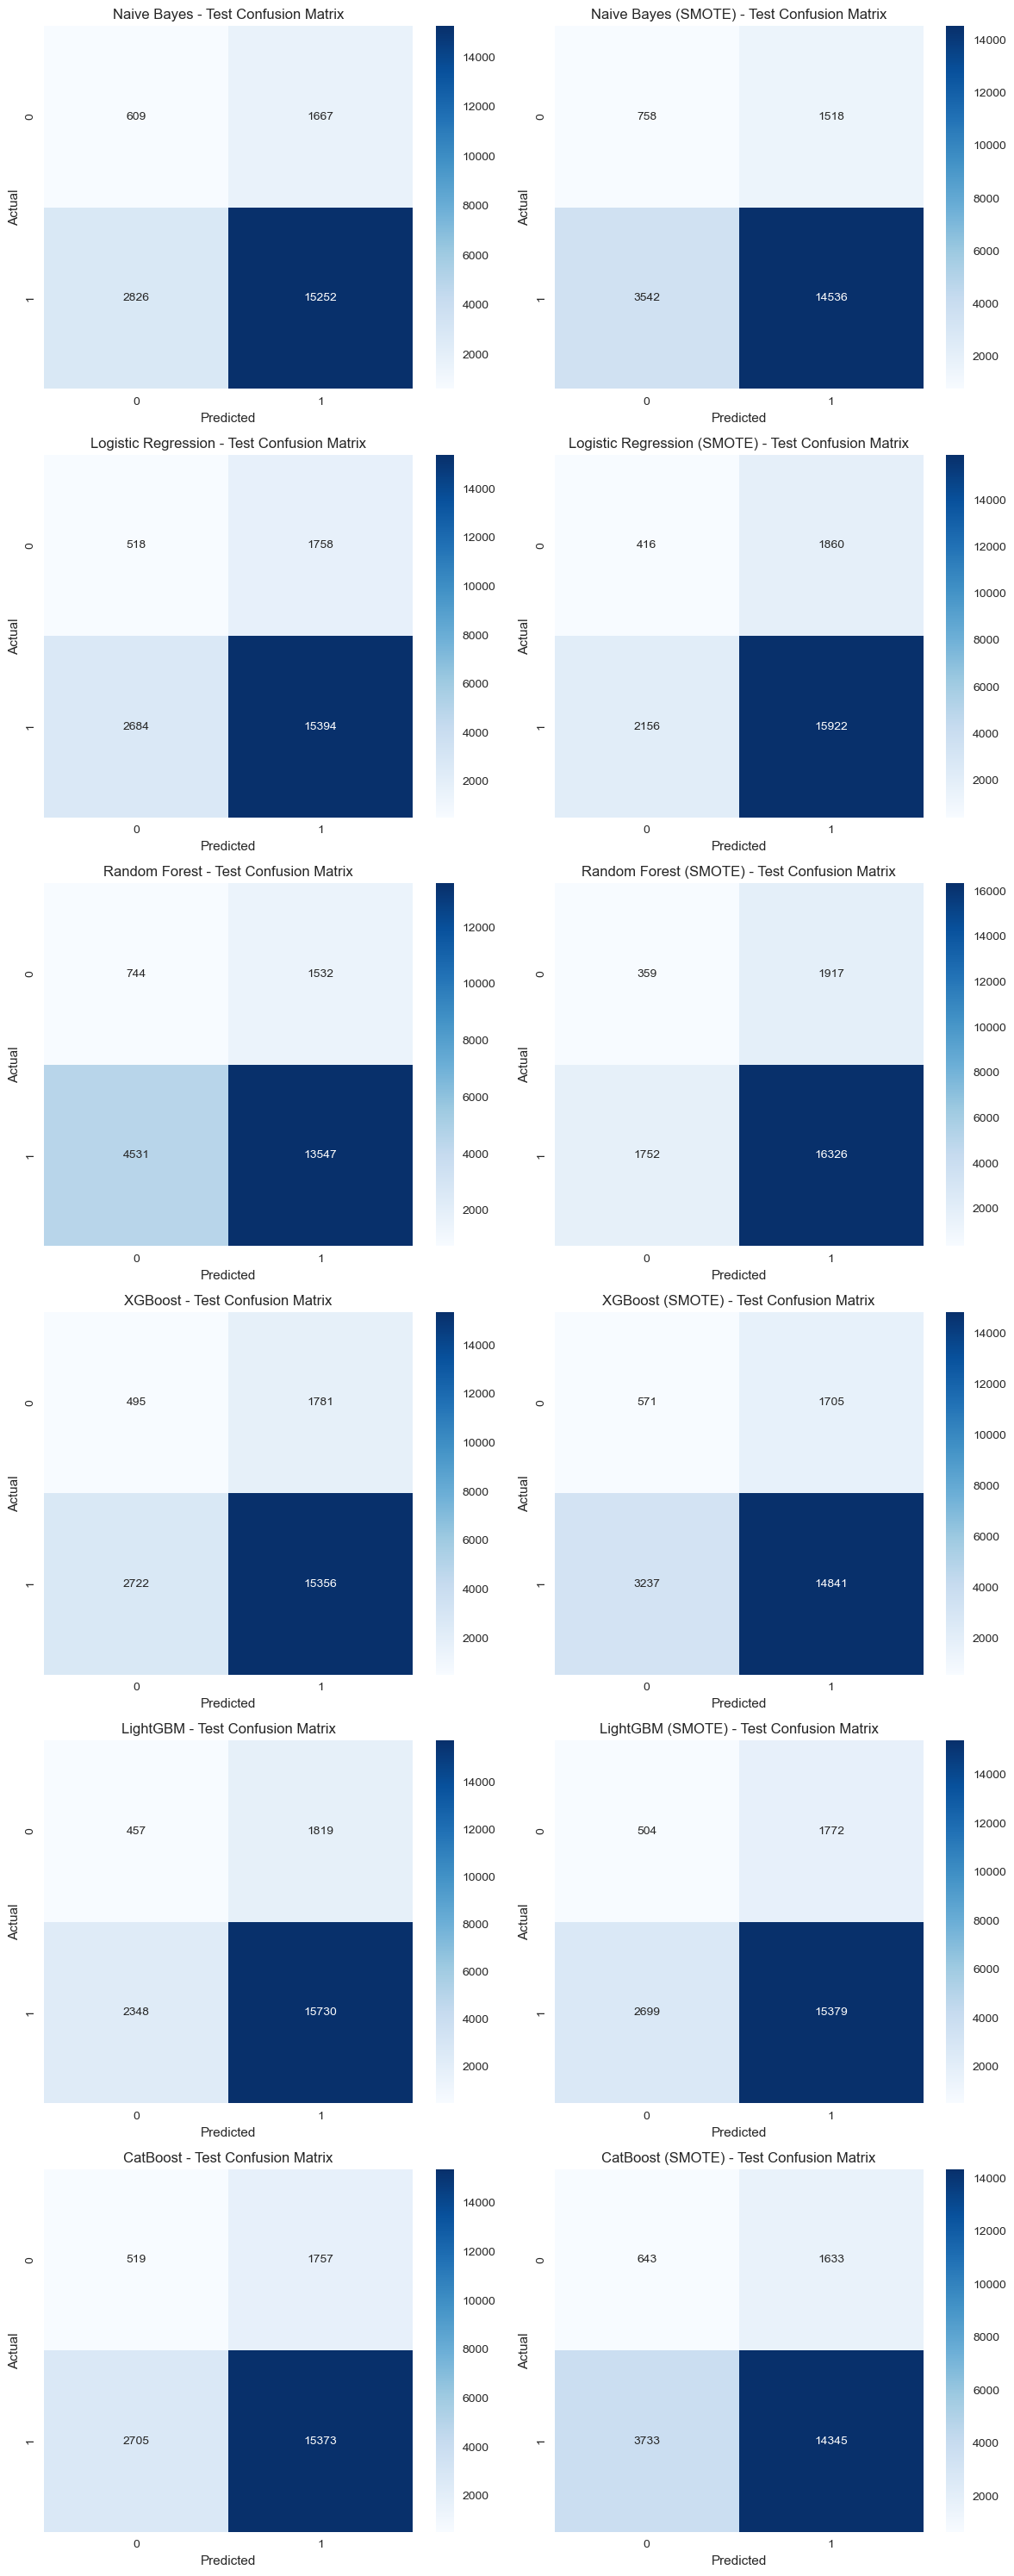

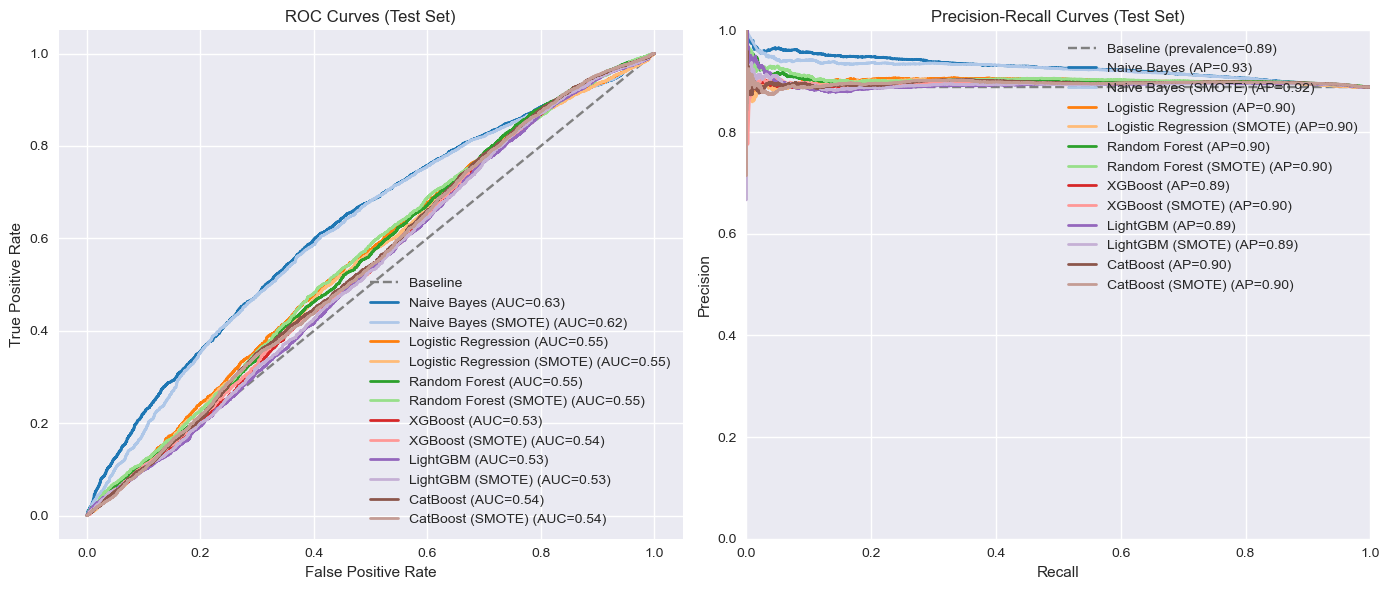

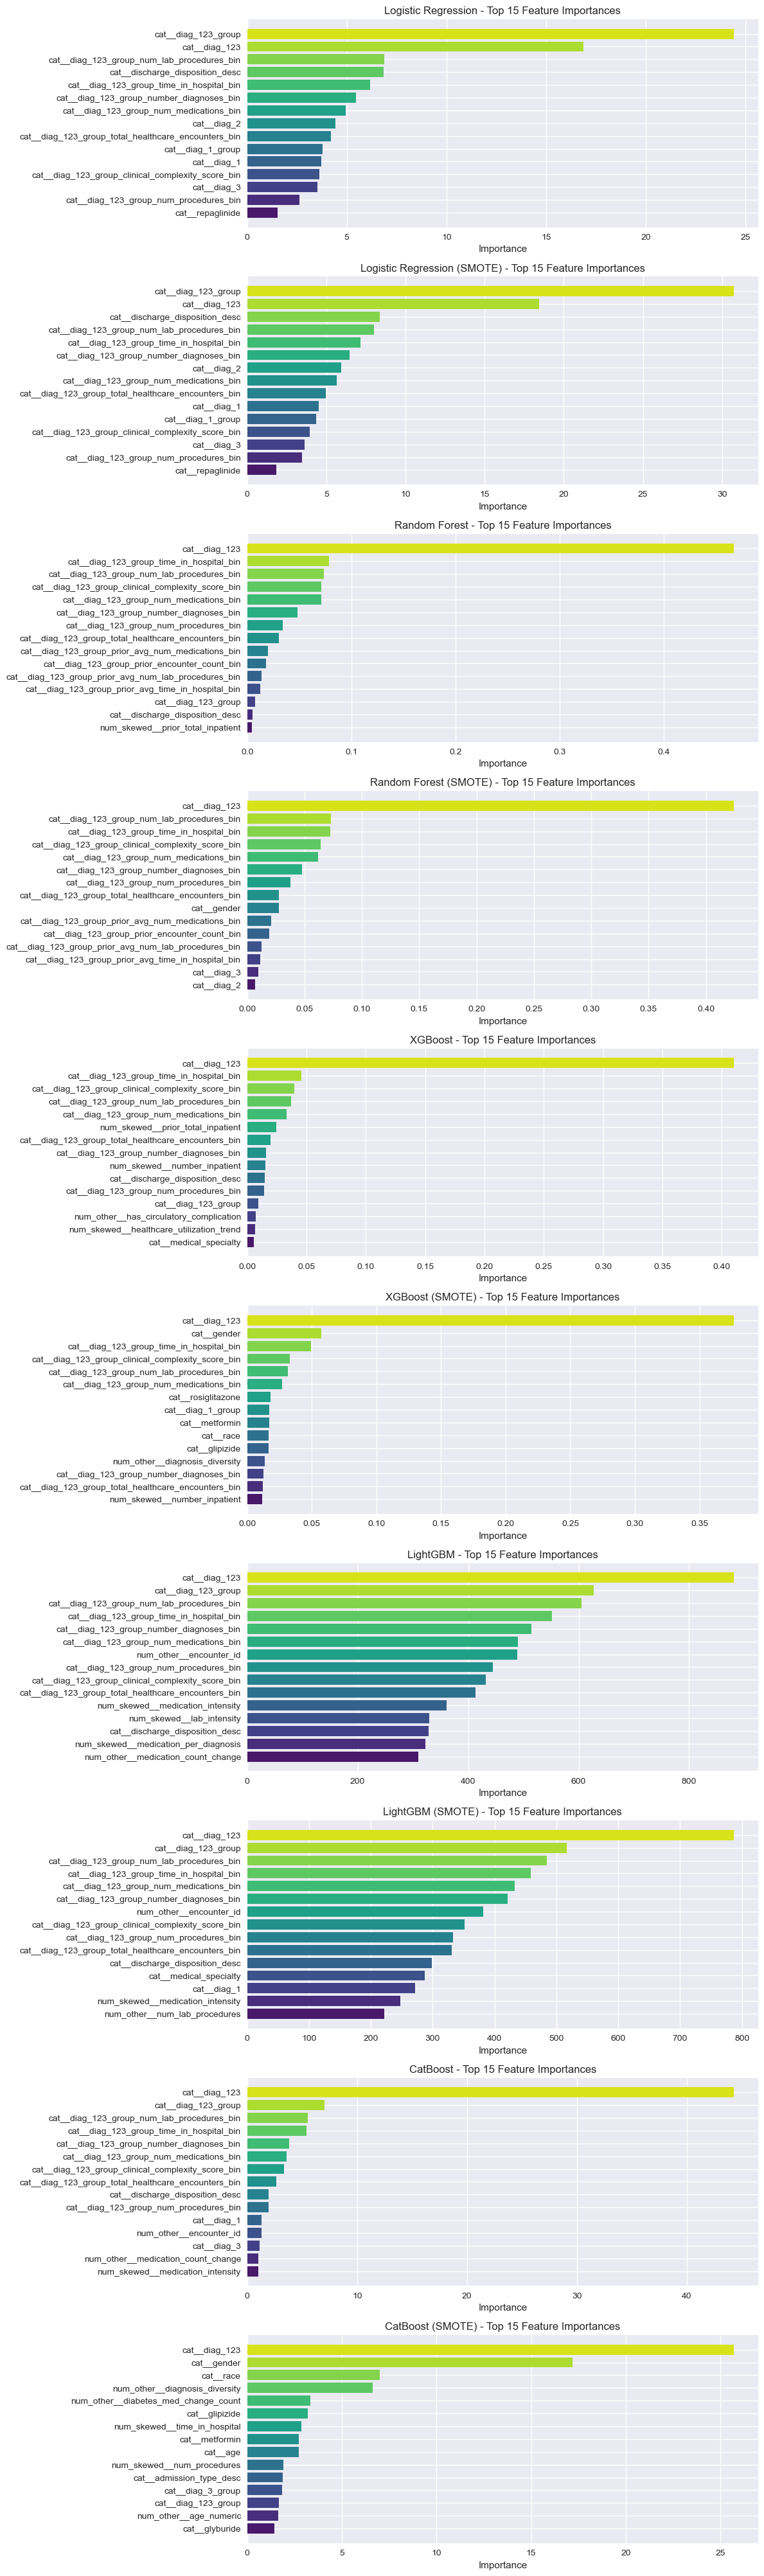

Detected model type: RandomForestClassifier
Using TreeExplainer for tree-based model
Using class 1 SHAP values for binary classification
SHAP contribution summary for ALL features (RandomForestClassifier, test set):
Top 20 most important features:
Using class 1 SHAP values for binary classification
SHAP contribution summary for ALL features (RandomForestClassifier, test set):
Top 20 most important features:


mean_abs_shap  mean_shap  \
cat__diag_123                                            0.134707   0.097064   
cat__diag_123_group_num_lab_procedures_bin               0.050600   0.026706   
cat__diag_123_group_time_in_hospital_bin                 0.048324   0.025296   
cat__diag_123_group_num_medications_bin                  0.044341   0.022802   
cat__diag_123_group_clinical_complexity_score_bin        0.041334   0.021764   
cat__diag_123_group_number_diagnoses_bin                 0.032250   0.014985   
cat__diag_123_group_num_procedures_bin                   0.024502   0.010778   
cat__diag_123_group_total_healthcare_encounters...       0.021793   0.010319   
cat__gender                                              0.012762   0.012543   
cat__diag_123_group_prior_encounter_count_bin            0.009303   0.004421   
cat__diag_123_group_prior_avg_num_medications_bin        0.008943   0.003265   
cat__diag_123_group_prior_avg_num_lab_procedure...       0.006488   0.002917   
cat__diag_3                                              0.006252   0.002326   
cat__discharge_disposition_desc                          0.005533   0.002068   
num_skewed__number_inpatient                             0.004869   0.001810   
cat__diag_123_group_prior_avg_time_in_hospital_bin       0.004724   0.002237   
cat__diag_1                                              0.004613   0.001027   
cat__diag_1_group                                        0.004587   0.001442   
num_other__number_diagnoses                              0.004354   0.000968   
cat__race                                                0.003905   0.002567   

                                                    feature_mean  
cat__diag_123                                           0.895727  
cat__diag_123_group_num_lab_procedures_bin              0.895633  
cat__diag_123_group_time_in_hospital_bin                0.896339  
cat__diag_123_group_num_medications_bin                 0.896135  
cat__diag_123_group_clinical_complexity_score_bin       0.896523  
cat__diag_123_group_number_diagnoses_bin                0.894125  
cat__diag_123_group_num_procedures_bin                  0.894204  
cat__diag_123_group_total_healthcare_encounters...      0.894345  
cat__gender                                             0.888531  
cat__diag_123_group_prior_encounter_count_bin           0.894108  
cat__diag_123_group_prior_avg_num_medications_bin       0.893494  
cat__diag_123_group_prior_avg_num_lab_procedure...      0.894154  
cat__diag_3                                             0.889241  
cat__discharge_disposition_desc                         0.888612  
num_skewed__number_inpatient                            0.010000  
cat__diag_123_group_prior_avg_time_in_hospital_bin      0.894174  
cat__diag_1                                             0.888932  
cat__diag_1_group                                       0.888604  
num_other__number_diagnoses                             0.002539  
cat__race                                               0.888550

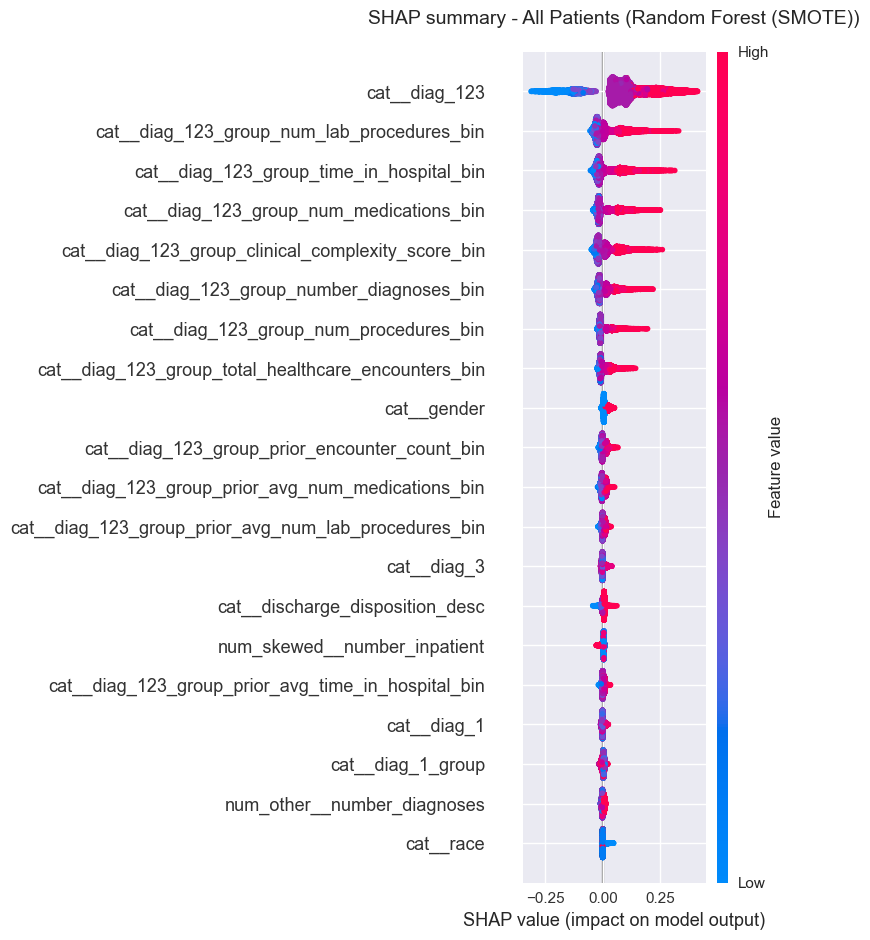

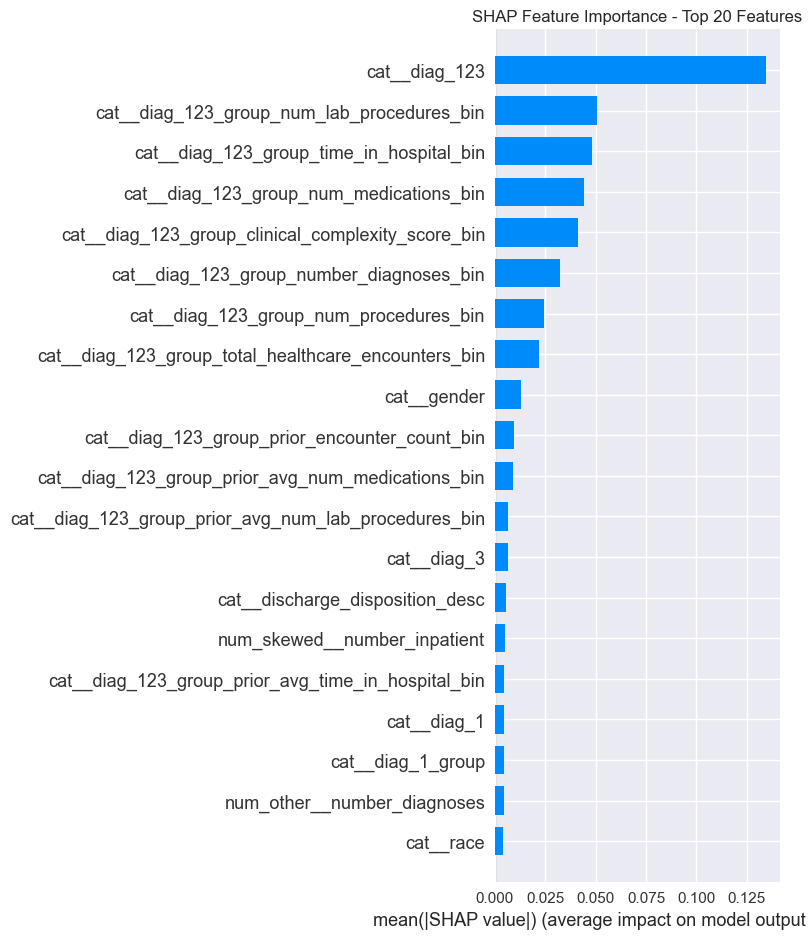


All DF pipeline completed successfully!
   Best model: Random Forest (SMOTE)
   Best F1 score: 0.8990
   SHAP analysis: Success (TreeExplainer)


In [126]:


# Run the pipeline for this group
pipeline_results = run_group_modeling_pipeline(
    df,
    "All Patients",
    target_col='readmitted_binary',
    test_size=0.2,
    random_state=42,
    shap_sample_size=300  # Reduced for faster execution
)

group_results[group_name] = pipeline_results
group_summaries[group_name] = pipeline_results['summary']

print(f"\nAll DF pipeline completed successfully!")

# Print key results
best_model = pipeline_results['best_model_name']
best_f1 = pipeline_results['best_model_payload']['test']['f1']
print(f"   Best model: {best_model}")
print(f"   Best F1 score: {best_f1:.4f}")

if 'error' not in pipeline_results['shap']:
    shap_type = pipeline_results['shap'].get('explainer_type', 'Unknown')
    print(f"   SHAP analysis: Success ({shap_type})")
else:
    print(f"   SHAP analysis: {pipeline_results['shap']['error']}")
            

In [127]:
# Performance analysis breakdown by selected features
X_test_final = pipeline_results['X_test_final']
y_test = pipeline_results['y_test']
best_estimator = pipeline_results['best_model_payload']['estimator']
test_metadata = df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]    
print(f'===All DF CONFUSION MATRIX ANALYSIS BY FEATURE===')
for feature in test_metadata.columns:
    print(f"\nConfusion breakdown by {feature}:")
    display(confusion_breakdown(best_estimator, X_test_final, y_test, test_metadata, feature))


===All DF CONFUSION MATRIX ANALYSIS BY FEATURE===

Confusion breakdown by race:


race  support   TN    FP    FN     TP  specificity    recall
3        Caucasian    14852  254  1410  1315  11873     0.152644  0.900288
1  AfricanAmerican     4371   86   406   338   3541     0.174797  0.912864
4         Hispanic      441    6    30    39    366     0.166667  0.903704
0                ?      326    9    31    31    255     0.225000  0.891608
5            Other      289    4    26    23    236     0.133333  0.911197
2            Asian       75    0    14     6     55     0.000000  0.901639


Confusion breakdown by age:


age  support  TN   FP   FN    TP  specificity    recall
7   [70-80)     5383  82  525  473  4303     0.135091  0.900963
6   [60-70)     4400  78  413  387  3522     0.158859  0.900998
5   [50-60)     3675  67  354  302  2952     0.159145  0.907191
8   [80-90)     2610  48  236  214  2112     0.169014  0.907997
4   [40-50)     2221  43  189  209  1780     0.185345  0.894922
3   [30-40)      933  18   81   76   758     0.181818  0.908873
9  [90-100)      366   9   42   29   286     0.176471  0.907937
2   [20-30)      332   5   37   26   264     0.119048  0.910345
1   [10-20)      324   7   32   30   255     0.179487  0.894737
0    [0-10)      110   2    8    6    94     0.200000  0.940000


Confusion breakdown by diag_1_group:


diag_1_group  support   TN   FP   FN  \
0                                         Circulatory     7091  116  668  597   
10                                        Respiratory     2548   40  249  220   
1                                            Diabetes     1930   38  169  182   
2                                           Digestive     1731   44  173  147   
6                                              Injury     1283   24  117  112   
7                                     Musculoskeletal      916   14  105   81   
4                                       Genitourinary      761   17   68   63   
8                                           Neoplasms      714   10   63   51   
17        symptoms, signs, and ill-defined conditions      596   13   50   50   
16                                   mental disorders      528    9   54   46   
3   Endocrine, nutritional and metabolic diseases,...      484    6   38   45   
15       diseases of the skin and subcutaneous tissue      448    1   42   43   
9                                               Other      391    7   40   38   
5                   Infectious and parasitic diseases      372   12   41   22   
14    diseases of the nervous system and sense organs      216    5   14   30   
13     diseases of the blood and blood-forming organs      171    2   13   15   
11  complications of pregnancy, childbirth, and th...      166    1   12   10   
12                               congenital anomalies        8    0    1    0   

      TP  specificity    recall  
0   5710     0.147959  0.905343  
10  2039     0.138408  0.902612  
1   1541     0.183575  0.894370  
2   1367     0.202765  0.902906  
6   1030     0.170213  0.901926  
7    716     0.117647  0.898369  
4    613     0.200000  0.906805  
8    590     0.136986  0.920437  
17   483     0.206349  0.906191  
16   419     0.142857  0.901075  
3    395     0.136364  0.897727  
15   362     0.023256  0.893827  
9    306     0.148936  0.889535  
5    297     0.226415  0.931034  
14   167     0.263158  0.847716  
13   141     0.133333  0.903846  
11   143     0.076923  0.934641  
12     7     0.000000  1.000000


Confusion breakdown by diag_2_group:


diag_2_group  support   TN   FP   FN  \
0                                         Circulatory     6824  120  638  588   
1                                            Diabetes     3608   62  343  304   
10                                        Respiratory     1919   30  180  155   
3   Endocrine, nutritional and metabolic diseases,...     1459   34  114  115   
4                                       Genitourinary     1207   20  137  107   
2                                           Digestive      775   20   77   65   
15       diseases of the skin and subcutaneous tissue      642   15   54   74   
9                                               Other      588    9   54   49   
16                                   mental disorders      502    3   48   46   
17        symptoms, signs, and ill-defined conditions      484   12   46   38   
8                                           Neoplasms      474    5   39   43   
13     diseases of the blood and blood-forming organs      474    5   53   54   
6                                              Injury      460   10   42   36   
5                   Infectious and parasitic diseases      356    6   32   34   
7                                     Musculoskeletal      283    1   34   21   
14    diseases of the nervous system and sense organs      190    7   17   16   
11  complications of pregnancy, childbirth, and th...       93    0    9    6   
12                               congenital anomalies       16    0    0    1   

      TP  specificity    recall  
0   5478     0.158311  0.903066  
1   2899     0.153086  0.905089  
10  1554     0.142857  0.909304  
3   1196     0.229730  0.912281  
4    943     0.127389  0.898095  
2    613     0.206186  0.904130  
15   499     0.217391  0.870855  
9    476     0.142857  0.906667  
16   405     0.058824  0.898004  
17   388     0.206897  0.910798  
8    387     0.113636  0.900000  
13   362     0.086207  0.870192  
6    372     0.192308  0.911765  
5    284     0.157895  0.893082  
7    227     0.028571  0.915323  
14   150     0.291667  0.903614  
11    78     0.000000  0.928571  
12    15          NaN  0.937500


Confusion breakdown by diag_3_group:


diag_3_group  support   TN   FP   FN  \
0                                         Circulatory     6156  104  580  494   
1                                            Diabetes     4132   78  364  349   
3   Endocrine, nutritional and metabolic diseases,...     1588   33  151  131   
9                                               Other     1481   20  145  129   
10                                        Respiratory     1382   26  127  131   
4                                       Genitourinary     1043   17   81  105   
2                                           Digestive      778   18   82   63   
16                                   mental disorders      637   12   64   56   
17        symptoms, signs, and ill-defined conditions      471    9   48   44   
15       diseases of the skin and subcutaneous tissue      436    4   41   39   
13     diseases of the blood and blood-forming organs      417    7   54   39   
5                   Infectious and parasitic diseases      374    6   31   41   
14    diseases of the nervous system and sense organs      373    8   35   34   
7                                     Musculoskeletal      352    4   41   30   
6                                              Injury      341    7   39   32   
8                                           Neoplasms      293    5   26   28   
11  complications of pregnancy, childbirth, and th...       82    1    4    4   
12                               congenital anomalies       18    0    4    3   

      TP  specificity    recall  
0   4978     0.152047  0.909722  
1   3341     0.176471  0.905420  
3   1273     0.179348  0.906695  
9   1187     0.121212  0.901976  
10  1098     0.169935  0.893409  
4    840     0.173469  0.888889  
2    615     0.180000  0.907080  
16   505     0.157895  0.900178  
17   370     0.157895  0.893720  
15   352     0.088889  0.900256  
13   317     0.114754  0.890449  
5    296     0.162162  0.878338  
14   296     0.186047  0.896970  
7    277     0.088889  0.902280  
6    263     0.152174  0.891525  
8    234     0.161290  0.893130  
11    73     0.200000  0.948052  
12    11     0.000000  0.785714